# Stability calculations

## -- LUVOIR --

In notebook 10, we calculated the PASTIS modes for all three currently designed apodizers for the LUVOIR A pupil. In this notebook, we will load the modes and calculate the maximum mode contributions $\sigma$ and strability requirements $\Delta \sigma$.

After that I also calculate the maximum segment contributions $\mu$.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from astropy.io import fits
import astropy.units as u
import hcipy as hc

os.chdir('../../pastis/')
import util_pastis as util
from e2e_simulators.luvoir_imaging_onephot import LuvoirAPLC

In [208]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Computer Modern Sans"]
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 16
import math as math
def to_precision(x,p):
    """
    returns a string representation of x formatted with a precision of p

    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """

    x = float(x)

    if x == 0.:
        return "0." + "0"*(p-1)

    out = []

    if x < 0:
        out.append("-")
        x = -x

    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)

    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)

    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1

    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1

    m = "%.*g" % (p, n)

    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)

    return "".join(out)
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'

linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [209]:
# Load aperture files needed for SM
nseg = 120
wvln = 638e-9

datadir = '/Users/pueyo/PythonPackages/PASTIS/LUVOIR_delivery_May2019/'
aper_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000.fits'
aper_ind_path = 'inputs/TelAp_LUVOIR_gap_pad01_bw_ovsamp04_N1000_indexed.fits'
aper_read = hc.read_fits(os.path.join(datadir, aper_path))
aper_ind_read = hc.read_fits(os.path.join(datadir, aper_ind_path))

pupil_grid = hc.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hc.Field(aper_read.ravel(), pupil_grid)
aper_ind = hc.Field(aper_ind_read.ravel(), pupil_grid)

wf_aper = hc.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(datadir, aper_ind_path))

poslist = []
for i in range(nseg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(poslist))

In [4]:
eunit = 1e-9

## Get the matrices 

In [5]:
savedpath = '/Users/pueyo/Documents/data_from_repos/pastis_data/2020-10-15T00-51-01_luvoir-medium'   # large apodizer LUVOIR
G_LO_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_LO_15.fits'))
G_LO_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_LO_15.fits'))
G_MID_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_MID_6.fits'))
G_MID_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_MID_6.fits'))
G_HI_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Re_matrix_num_HI_24.fits'))
G_HI_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_Im_matrix_num_HI_24.fits'))
G_LOWFS_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_LOWFS_Re_matrix_num_LO_15.fits'))
G_LOWFS_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_LOWFS_Im_matrix_num_LO_15.fits'))
G_OBWFS_real = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_OBWFS_Re_matrix_num_MID_6.fits'))
G_OBWFS_imag = fits.getdata(os.path.join(savedpath, 'matrix_numerical', 'EFIELD_OBWFS_Im_matrix_num_MID_6.fits'))

In [6]:
from config import CONFIG_INI

In [7]:
design = 'medium'

In [8]:
overall_dir = util.create_data_path(CONFIG_INI.get('local', 'local_data_path'), telescope = 'luvoir-'+design)
os.makedirs(overall_dir, exist_ok=True)
resDir = os.path.join(overall_dir, 'matrix_numerical')

# Moving parts parameters
max_LO = CONFIG_INI.getint('calibration', 'max_LO')
max_MID = CONFIG_INI.getint('calibration', 'max_MID')
max_HI = CONFIG_INI.getint('calibration', 'max_HI')
num_DM_act = CONFIG_INI.getint('calibration', 'num_DM_act')

# General telescope parameters
nb_seg = CONFIG_INI.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_INI.getfloat('LUVOIR', 'lambda') * 1e-9  # m
diam = CONFIG_INI.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration') * 1e-9   # m

# Image system parameters
im_lamD = CONFIG_INI.getfloat('numerical', 'im_size_lamD_hcipy')  # image size in lambda/D
sampling = CONFIG_INI.getfloat('numerical', 'sampling')

/Users/pueyo/Documents/data_from_repos/pastis_data



In [9]:
optics_input = CONFIG_INI.get('LUVOIR', 'optics_path')
luvoir = LuvoirAPLC(optics_input, design, sampling)

/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:68: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [10]:
segment = hc.hexagonal_aperture(luvoir.segment_circum_diameter, np.pi / 2)
segment_sampled = hc.evaluate_supersampled(segment,luvoir.pupil_grid, 1)
aper2, segs2 = hc.make_segmented_aperture(segment,luvoir.seg_pos, segment_transmissions=1, return_segments=True)
luvoir_segmented_pattern = hc.evaluate_supersampled(aper2, luvoir.pupil_grid, 1)
seg_evaluated = []
for seg_tmp in segs2:
    tmp_evaluated = hc.evaluate_supersampled(seg_tmp, luvoir.pupil_grid, 1)
    seg_evaluated.append(tmp_evaluated)

In [11]:
### Instantiate the moving parts as a DMs a la HCIPy
luvoir.make_LO_Modes(max_LO)
luvoir.make_segment_zernike_primary(max_MID)
luvoir.make_HI_Modes(max_HI)
luvoir.make_DM(num_DM_act)

In [12]:
n_LO = luvoir.zm.num_actuators
n_MID = luvoir.sm.num_actuators
n_HI = luvoir.fm.num_actuators
n_DM = luvoir.dm.num_actuators


### Set up the sampling for zernike sensors
z_pup_downsample = CONFIG_INI.getfloat('numerical', 'z_pup_downsample')
N_pup_z = np.int(luvoir.pupil_grid.shape[0] / z_pup_downsample)
grid_zernike = hc.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)


### Dark hole mask
dh_outer = hc.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_inner = hc.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
dh_mask = (dh_outer - dh_inner).astype('bool')

In [13]:
### Reference images for contrast normalization and coronagraph floor
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes

unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)

dh_intensity = (unaberrated_coro_psf / norm) * dh_mask
contrast_floor = np.mean(dh_intensity[np.where(dh_mask != 0)])
print('contrast floor: {}'.format(contrast_floor))
nonaberrated_coro_psf, ref,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter_ref['at_science_focus'].electric_field

contrast floor: 3.924822663883781e-11


# Check the 0 th actuators

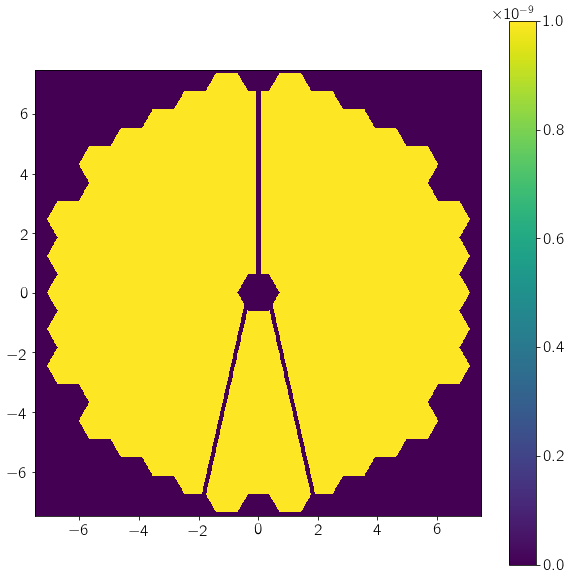

In [14]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
input_wf = luvoir.wf_aper
LO_modes[0] = eunit / 2
luvoir.zm.actuators  = LO_modes
tmp_pupil = luvoir.zm(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(tmp_pupil.phase/tmp_pupil.wavenumber)
plt.colorbar()

# Make matrices

In [15]:
mat_LO = np.zeros([n_LO-1, n_LO-1])
for i in range(1, n_LO):
    for j in range(1, n_LO):
        tmpI = G_LO_real[i]+1j*G_LO_imag[i] - Efield_ref
        tmpJ = G_LO_real[j]+1j*G_LO_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_LO[i-1, j-1] = contrast        

In [16]:
mat_MID = np.zeros([n_MID, n_MID])
for i in range(0, n_MID):
    for j in range(0, n_MID):
        tmpI = G_MID_real[i]+1j*G_MID_imag[i] - Efield_ref
        tmpJ = G_MID_real[j]+1j*G_MID_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_MID[i, j] = contrast    

In [17]:
mat_HI = np.zeros([n_HI, n_HI])
for i in range(0, n_HI):
    for j in range(0, n_HI):
        tmpI = G_HI_real[i]+1j*G_HI_imag[i] - Efield_ref
        tmpJ = G_HI_real[j]+1j*G_HI_imag[j] - Efield_ref
        test = np.real(tmpI*np.conj(tmpJ))
        dh_test = (test / norm) * dh_mask
        contrast = np.mean(dh_test[np.where(dh_mask != 0)])
        mat_HI[i, j] = contrast    

## Read eigenmodes and eigenvalues

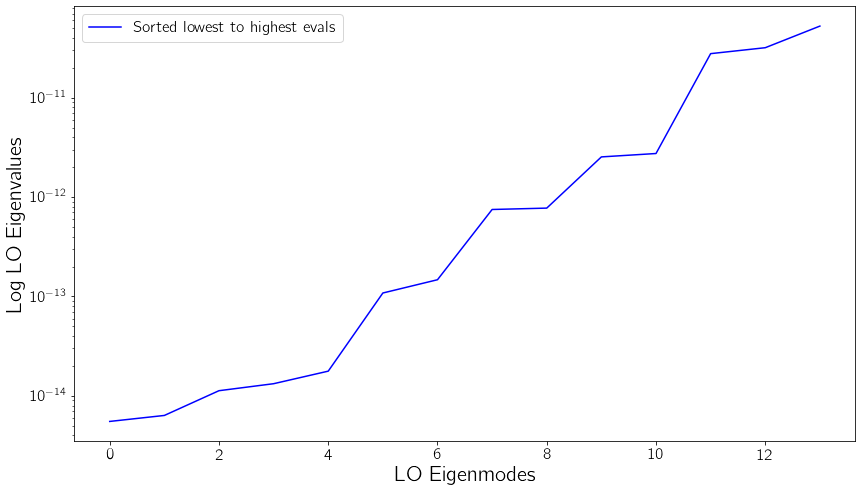

In [512]:
evalsLO, evecsLO = np.linalg.eig(mat_LO)
sorted_evalsLO = np.sort(evalsLO)
sorted_indicesLO = np.argsort(evalsLO)
sorted_evecsLO = evecsLO[:, sorted_indicesLO]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsLO, label='Sorted lowest to highest evals',linewidth=1.5,color = 'blue')
plt.semilogy()
plt.xlabel('LO Eigenmodes')
plt.ylabel('Log LO Eigenvalues')
plt.legend()
file_name = 'LO_eigenvalues' + '.pdf'
fig.savefig(file_name)

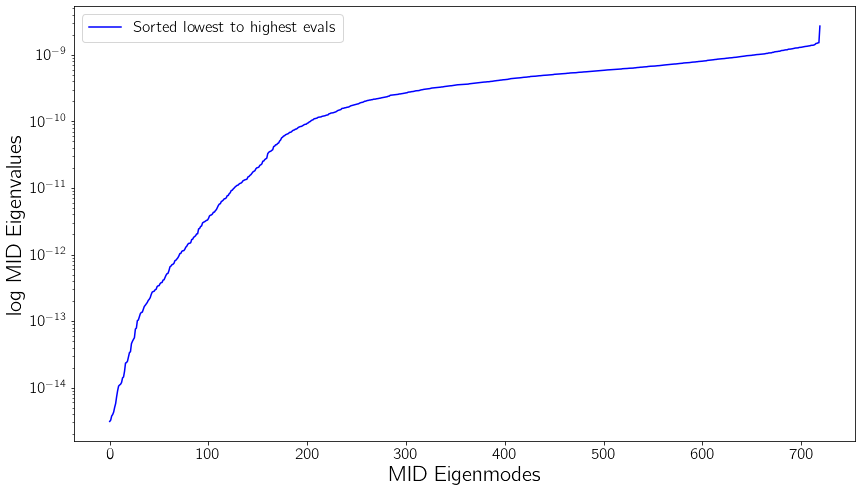

In [514]:
evalsMID, evecsMID = np.linalg.eig(mat_MID)
sorted_evalsMID = np.sort(evalsMID)
sorted_indicesMID = np.argsort(evalsMID)
sorted_evecsMID = evecsMID[:, sorted_indicesMID]
plt.figure(figsize=(14, 8))
#plt.pMIDt(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsMID, label='Sorted lowest to highest evals',linewidth=1.5,color = 'blue')
plt.semilogy()
plt.xlabel('MID Eigenmodes')
plt.ylabel('log MID Eigenvalues')
plt.legend()
file_name = 'MID_eigenvalues' + '.pdf'
fig.savefig(file_name)

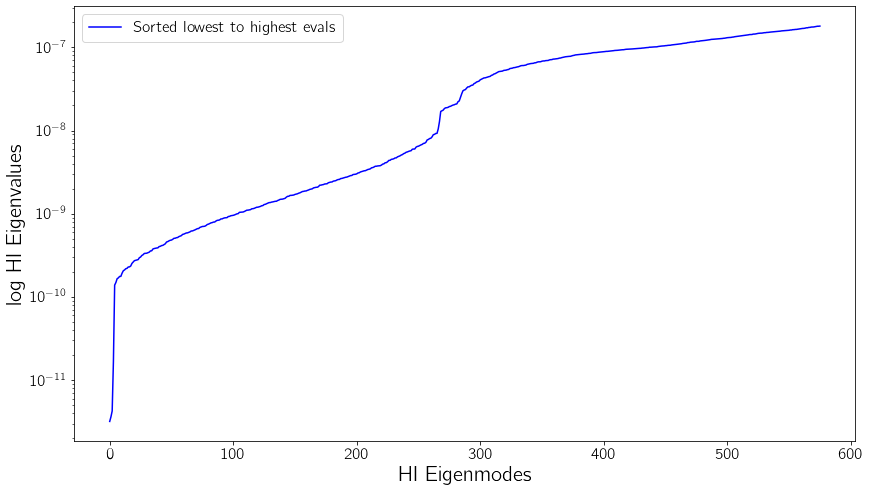

In [515]:
evalsHI, evecsHI = np.linalg.eig(mat_HI)
sorted_evalsHI = np.sort(evalsHI)
sorted_indicesHI = np.argsort(evalsHI)
sorted_evecsHI = evecsHI[:, sorted_indicesHI]
plt.figure(figsize=(14, 8))
#plt.pHIt(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evalsHI, label='Sorted lowest to highest evals',linewidth=1.5,color = 'blue')
plt.semilogy()
plt.xlabel('HI Eigenmodes')
plt.ylabel('log HI Eigenvalues')
plt.legend()
file_name = 'HI_eigenvalues' + '.pdf'
fig.savefig(file_name)

# Check the 0 th and end modes

In [524]:
npup = np.int(np.sqrt(luvoir.pupil_grid.x.shape))
aper_mask = np.reshape(luvoir.aper,[npup,npup])

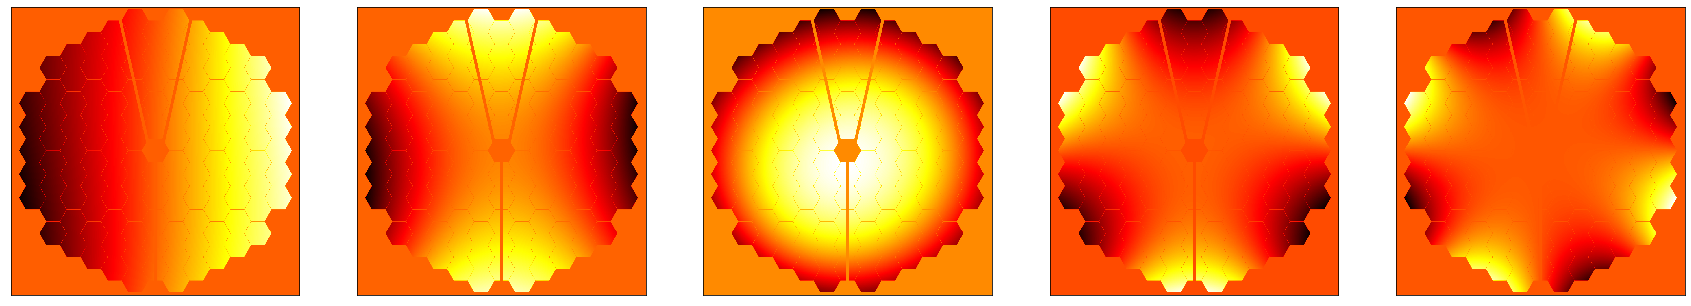

In [527]:
poked_modes = [0,2,4,6,9]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    LO_modes[1:n_LO] = eunit / 2 *sorted_evecsLO[poked_modes[pp],:]
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.zm.surface
#     tmp_psf_poke, ref, = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
#     detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(1, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[qq].imshow(phases[qq]*aper_mask,cmap = 'hot')
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'LO_PASTIS_modes' + '.pdf'
fig.savefig(file_name)

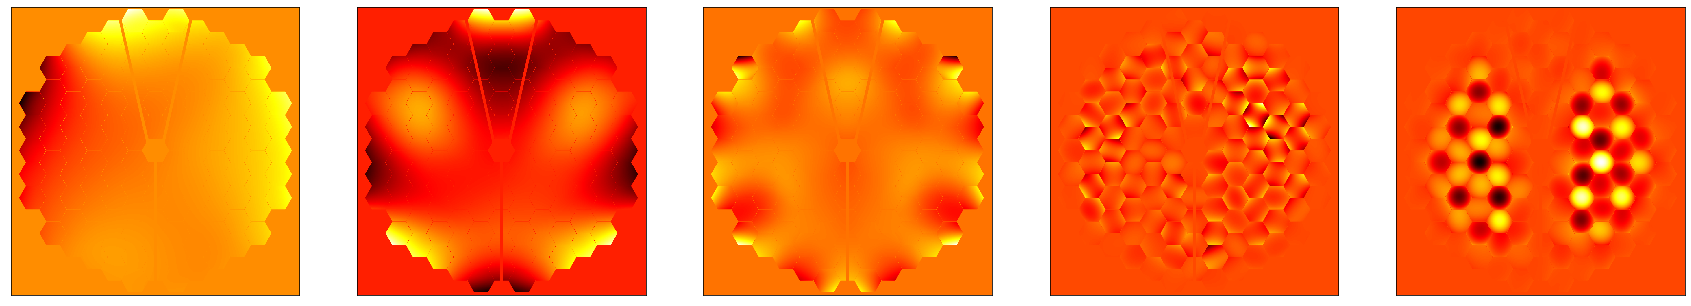

In [529]:
poked_modes = np.asarray([0,13,34,446,717])
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    MID_modes = eunit / 2 *sorted_evecsMID[:,poked_modes[pp]]
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.sm.surface
#     tmp_psf_poke, ref, = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
#     detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(1, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[qq].imshow(phases[qq],cmap = 'hot')
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'MID_PASTIS_modes' + '.pdf'
fig.savefig(file_name)

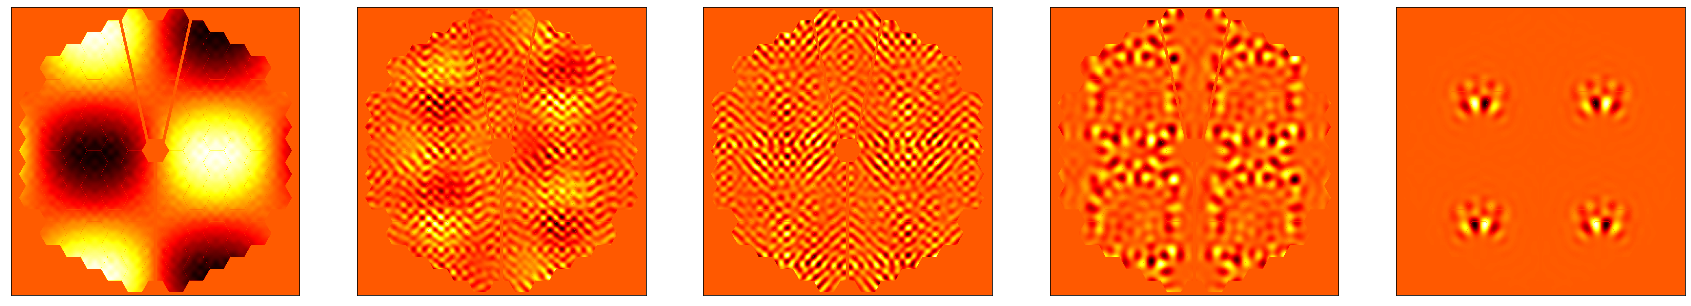

In [530]:
poked_modes = np.asarray([0,13,34,446,574])
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    HI_modes = eunit / 2 *sorted_evecsHI[:,poked_modes[pp]]
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.fm.surface
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
fig, axs = plt.subplots(1, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[qq].imshow(phases[qq],cmap = 'hot')
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'HI_PASTIS_modes' + '.pdf'
fig.savefig(file_name)

In [531]:
# Calculate single sigma - remember that we start numbering at 0 because of python
def get_sigma(cstat, nseg, eigenval):
#     sigma = np.sqrt((cstat - c_zero) / ((nseg-1)*eigenval))
    sigma = np.sqrt((cstat) / ((nseg-1)*eigenval))

    return sigma

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

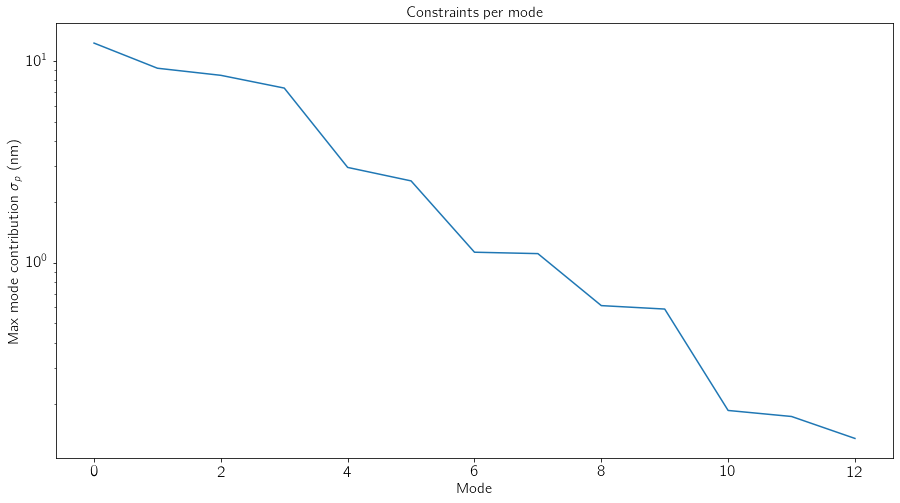

In [532]:
c_stat = 4e-11/3
sigmasLO = get_sigma(c_stat, n_LO, sorted_evalsLO)
plt.figure(figsize=(15, 8))
plt.plot(sigmasLO[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

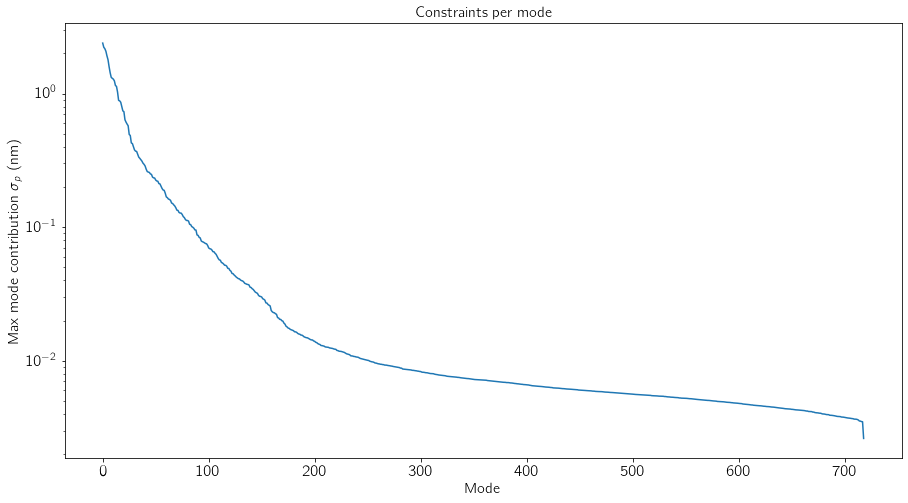

In [533]:
c_stat = 4e-11/3
sigmasMID = get_sigma(c_stat, n_MID, sorted_evalsMID)
plt.figure(figsize=(15, 8))
plt.plot(sigmasMID[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

Text(0, 0.5, 'Max mode contribution $\\sigma_p$ (nm)')

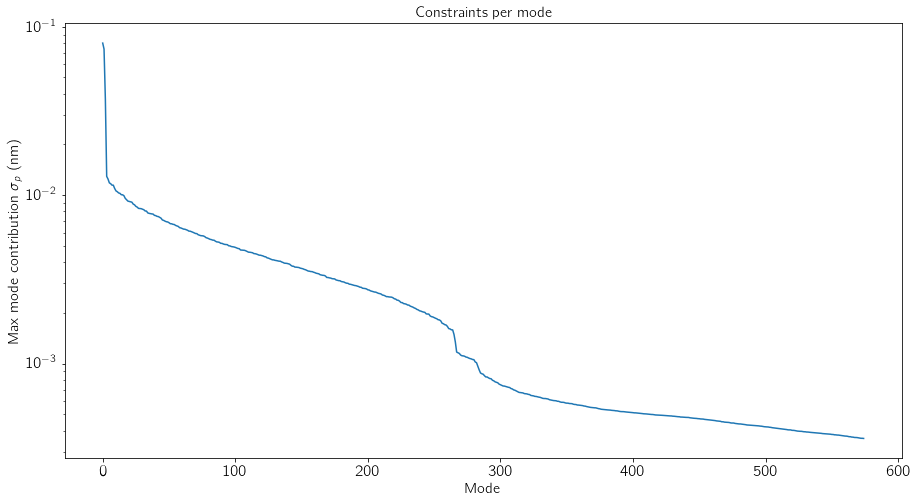

In [534]:
c_stat = 4e-11/3
sigmasHI = get_sigma(c_stat, n_HI, sorted_evalsHI)
plt.figure(figsize=(15, 8))
plt.plot(sigmasHI[1:])
plt.semilogy()
plt.title('Constraints per mode', size=15)
plt.xlabel('Mode', size=15)
plt.ylabel('Max mode contribution $\sigma_p$ (nm)', size=15)

In [535]:
c_dyn = 1e-11
# Calculate the Delta Cs
def get_delta_sigma(cdyn, nseg, eigenval):
    del_sigma = np.sqrt(cdyn / (np.sqrt(nseg-1)*eigenval))
    return del_sigma

So this part dos not work proprly yet. We need to check is a little more. I believe the problem is the raw contrast not being subtractd at the right place

## Segment based constraints

In [537]:
c_target = 4e-11/3

In [877]:
modestosegsLO = np.linalg.pinv(sorted_evecsLO)
modestosegsMID = np.linalg.pinv(sorted_evecsMID)
modestosegsHI = np.linalg.pinv(sorted_evecsHI)
# # Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
# c_avg = []
# for i in range(number_of_modes):
#     c_avg.append(util.pastis_contrast(sorted_evecs[:, i] * u.nm, matrix) + baseline_contrast)

# # Calculate segment requirements
# mu_map = np.sqrt(
#     ((c_target - baseline_contrast) / number_of_modes) / (np.dot(c_avg - baseline_contrast, np.square(modestosegs))))

# Calculate all mean contrasts of the pastis modes directly (as-is, with natural normalization)
c_avgLO = []
for i in range(n_LO-1):
    c_avgLO.append(util.pastis_contrast(sorted_evecsLO[:, i] * u.nm, mat_LO) )
    
c_avgMID = []
for i in range(n_MID):
    c_avgMID.append(util.pastis_contrast(sorted_evecsMID[:, i] * u.nm, mat_MID) )

c_avgHI = []
for i in range(n_HI):
    c_avgHI.append(util.pastis_contrast(sorted_evecsHI[:, i] * u.nm, mat_HI) )

# Calculate segment requirements
mu_mapLO = np.sqrt(
    ((c_target ) / (n_LO-1)) / (np.dot(c_avgLO, np.square(modestosegsLO))))
mu_mapMID = np.sqrt(
    ((c_target ) / (n_MID-1)) / (np.dot(c_avgMID, np.square(modestosegsMID))))
mu_mapHI = np.sqrt(
    ((c_target ) / (n_HI-1)) / (np.dot(c_avgHI, np.square(modestosegsHI))))
# c_avgLO = []
# for i in range(n_LO-1):
#     c_avgLO.append(util.pastis_contrast(sorted_evecsLO[:, i] * u.nm, mat_LO) )

In [878]:
N_zernike = max_MID
zernike_coeffs_numaps = np.zeros([N_zernike,n_MID])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([n_MID])
    for pp in range(120):
        zernike_coeffs_tmp[qq+(pp)*N_zernike] = mu_mapMID[qq+(pp)*N_zernike]
    zernike_coeffs_numaps[qq] = zernike_coeffs_tmp
zernike_coeffs_table = np.zeros([N_zernike,120])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([120])
    for pp in range(120):
        zernike_coeffs_table[qq,pp] = mu_mapMID[qq+(pp)*N_zernike]
nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = eunit*zernike_coeffs_numaps[qq]/2
    luvoir.sm.actuators = zernike_coeffs*10**(12)
#     nu_maps.append(luvoir.sm(luvoir.wf_aper).phase/luvoir.wf_aper.wavenumber)
    nu_maps.append(luvoir.sm.surface)

0
1
2
3
4
5


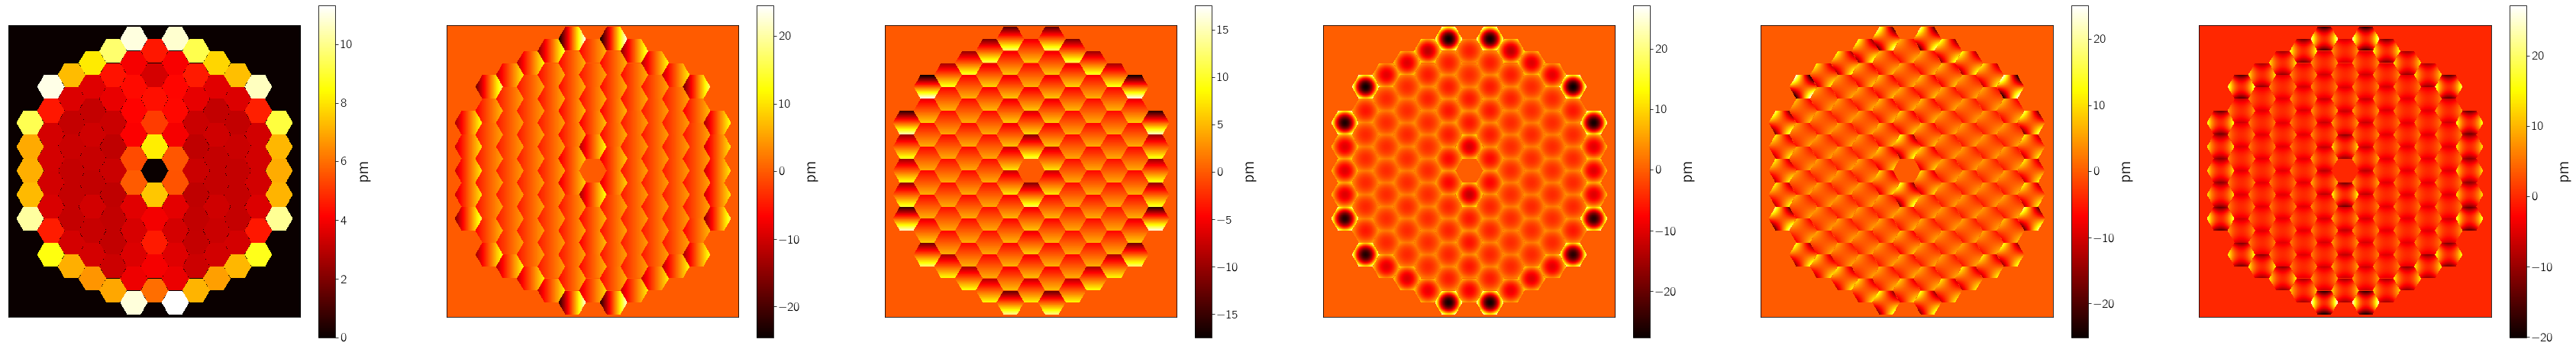

In [879]:
#     detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(1,len(nu_maps),figsize=(60,20))
for qq in range(0,len(nu_maps)):
    print(qq)
    phaseplot = axs[qq].imshow(np.reshape(nu_maps[qq],[npup,npup]),cmap = 'hot')
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
    clb=  fig.colorbar(phaseplot,ax = axs[qq],shrink=0.4)
    clb.set_label('pm', rotation=90)
#     plt.tight_layout(h_pad=1)
plt.show()
file_name = 'MID_requirements_figure' + '.pdf'
fig.savefig(file_name)

In [541]:
# for pp in range(0,max_MID):
#     fig, ax = plt.subplots(ncols=1)
#     img1 = hc.imshow_field(nu_maps[pp]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
#     clb = fig.colorbar(img1)
#     clb.set_label('pm', rotation=90)
#     plt.tight_layout(h_pad=1)

In [880]:
import astropy.table

In [883]:
ZernikeList = []
for pp in range(0,n_LO-1):
    ZernikeList.append('Global Z' + np.str(pp +1));
# ZernikeList.append('LO rms')

In [896]:
np.sqrt(np.sum(mu_mapLO**2))

17.810234156878877

In [546]:
table_LO = astropy.table.Table()
LO_Values_col = astropy.table.Table.Column(
        name = '$\Delta \epsilon_{11}^{LO}$ (nm)',
        data = mu_mapLO, dtype = float, format="7.2f")
LO_Labels_col = astropy.table.Table.Column(
        name = 'LO Modes', data = ZernikeList, dtype = str)
table_LO.add_column(LO_Labels_col)
table_LO.add_column(LO_Values_col)

In [724]:
table_LO

<Table length=14>
 LO Modes  $\Delta \epsilon_{11}^{LO}$ (nm)
  str10                float64             
---------- --------------------------------
 Global Z1                            11.48
 Global Z2                            10.47
 Global Z3                             3.19
 Global Z4                             4.73
 Global Z5                             5.01
 Global Z6                             1.08
 Global Z7                             1.12
 Global Z8                             2.91
 Global Z9                             2.53
Global Z10                             0.13
Global Z11                             0.19
Global Z12                             0.17
Global Z13                             0.58
Global Z14                             0.60

In [554]:
filename = 'Table_LO_w11.csv'
table_LO.write(filename, format='csv',overwrite=True)
filename = 'Table_LO_w11.tex'
table_LO.write(filename, format='latex',overwrite=True)

In [555]:
zernike_coeffs_numaps_max = np.zeros(max_MID)
for pp in range(0,max_MID):
    zernike_coeffs_numaps_max[pp] = np.max(zernike_coeffs_table[pp,:])*1000/2
zernike_coeffs_numaps_min = np.zeros(max_MID)
for pp in range(0,max_MID):
    zernike_coeffs_numaps_min[pp] = np.min(zernike_coeffs_table[pp,:])*1000/2
zernike_coeffs_numaps_median = np.zeros(max_MID)
for pp in range(0,max_MID):
    zernike_coeffs_numaps_median[pp] = np.median(zernike_coeffs_table[pp,:])*1000/2

In [732]:
ZernikeList = []
for pp in range(0,max_MID):
    ZernikeList.append('Segment Z' + np.str(pp));

In [889]:
zernike_coeffs_numaps_max

array([11.3388481 , 12.39850675, 10.317505  , 15.94535831, 11.87395285,
       11.33721327])

In [894]:
np.sqrt(np.sum(zernike_coeffs_numaps_min**2))

6.301786302545512

In [893]:
np.sqrt(np.sum(zernike_coeffs_numaps_median**2))

7.780286655826039

In [895]:
np.sqrt(np.sum(zernike_coeffs_numaps_max**2))

30.207961994490333

In [559]:
table_MID = astropy.table.Table()
MID_Max_Values_col = astropy.table.Table.Column(
        name = 'max $ \Delta \epsilon_{11}^{MID}$ (pm)',
        data = zernike_coeffs_numaps_max, dtype = float, format="7.1f")
MID_Min_Values_col = astropy.table.Table.Column(
        name = 'min$ \Delta \epsilon_{11}^{MID}$ (pm)',
        data = zernike_coeffs_numaps_min, dtype = float, format="7.1f")
MID_Median_Values_col = astropy.table.Table.Column(
        name = 'median$ \Delta \epsilon_{11}^{MID}$ (pm)',
        data = zernike_coeffs_numaps_median, dtype = float, format="7.2f")
MID_Labels_col = astropy.table.Table.Column(
        name = 'MID Modes', data = ZernikeList, dtype = str)
table_MID.add_column(MID_Labels_col)
table_MID.add_column(MID_Max_Values_col)
table_MID.add_column(MID_Min_Values_col)
table_MID.add_column(MID_Median_Values_col)

In [575]:
table_MID

<Table length=6>
MID Modes  ... median$ \Delta \epsilon_{11}^{MID}$ (pm)
  str10    ...                 float64                 
---------- ... ----------------------------------------
Segment Z0 ...                                     3.78
Segment Z1 ...                                     3.00
Segment Z2 ...                                     2.93
Segment Z3 ...                                     2.96
Segment Z4 ...                                     3.11
Segment Z5 ...                                     3.20

In [576]:
filename = 'Table_MID_w11.csv'
table_MID.write(filename, format='csv',overwrite=True)
filename = 'Table_MID_w11.tex'
table_MID.write(filename, format='latex',overwrite=True)

In [561]:
fourier_grid = hc.make_pupil_grid(dims=max_HI, diameter=max_HI)
rho0 = np.sqrt(fourier_grid.x**2+fourier_grid.y**2)
rho = np.sort(rho0)

Text(0, 0.5, 'log HI requirement, pm')

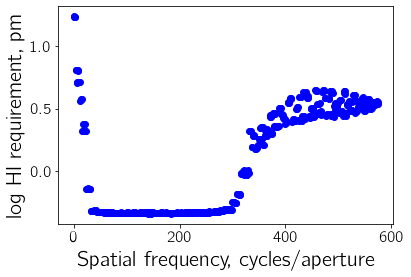

In [566]:
plt.plot(np.log10(mu_mapHI*1000),'bo')
plt.xlabel('Spatial frequency, cycles/aperture')
plt.ylabel('log HI requirement, pm')

In [628]:
mu_mapHI_Fudged = np.zeros(n_HI)
mu_mapHI_Fudged[20:300] = mu_mapHI[20:300]

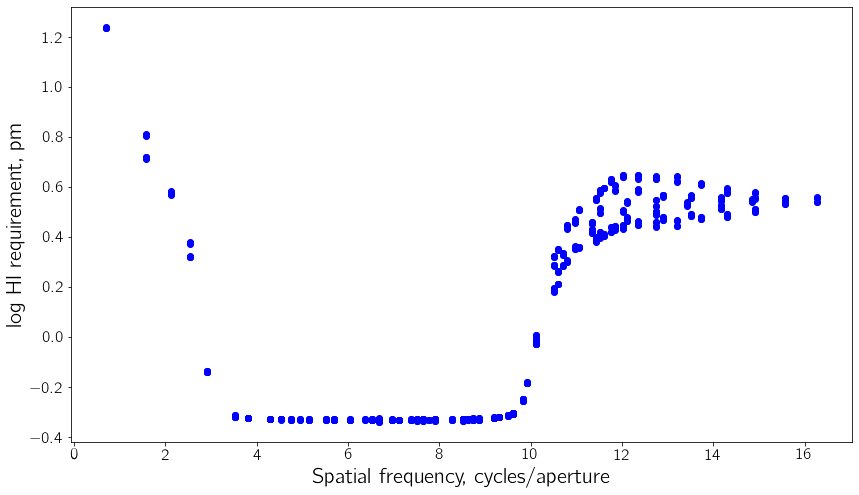

In [565]:
plt.figure(figsize=(14, 8))
plt.plot(rho,np.log10(mu_mapHI*1000),'bo')
plt.xlabel('Spatial frequency, cycles/aperture')
plt.ylabel('log HI requirement, pm')
file_name = 'HI_requirements_figure' + '.pdf'
fig.savefig(file_name)

In [567]:
SFList = ['Inside DH','Oustide DH']
SFreq = [np.mean(mu_mapHI[40:210])*1000,np.mean(mu_mapHI[450:470])*1000]

In [571]:
table_HI = astropy.table.Table()
HI_Values_col = astropy.table.Table.Column(
        name = ' $ \Delta \epsilon_{11}^{HI}$ (pm)',
        data = SFreq, dtype = float, format="7.2f")
HI_Labels_col = astropy.table.Table.Column(
        name = 'MID Modes', data = SFList, dtype = str)
table_HI.add_column(HI_Labels_col)
table_HI.add_column(HI_Values_col)

In [725]:
table_HI

<Table length=2>
MID Modes   $ \Delta \epsilon_{11}^{HI}$ (pm)
  str10                 float64              
---------- ----------------------------------
 Inside DH                               0.47
Oustide DH                               3.32

In [574]:
filename = 'Table_HI_w11.csv'
table_HI.write(filename, format='csv',overwrite=True)
filename = 'Table_HI_w11.tex'
table_HI.write(filename, format='latex',overwrite=True)

# Check the normalization of each poked mode

In [49]:
LO_mode_rms_v1 = np.zeros(n_LO-1)
LO_mode_rms_v2 = np.zeros(n_LO-1)
contrast_check_LO = np.zeros(n_LO-1)
for pp in range(1,n_LO):
#     print(pp)
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    LO_modes[pp] = eunit / 2
    luvoir.zm.actuators  = LO_modes
    tmp_pupil = luvoir.zm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*luvoir.aper
    LO_mode_rms_v1[pp-1] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    wavefront_map_tmp = luvoir.zm.opd*luvoir.aper
    LO_mode_rms_v2[pp-1] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_LO[pp-1] = test_contrast

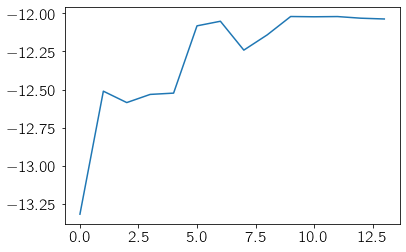

In [50]:
plt.plot(np.log10(np.abs(mu_mapLO**2*contrast_check_LO)))

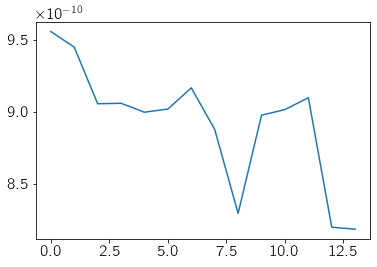

In [51]:
plt.plot(LO_mode_rms_v2)

In [52]:
MID_mode_rms_v1 = np.zeros(n_MID)
MID_mode_rms_v2 = np.zeros(n_MID)
contrast_check_MID = np.zeros(n_MID)
seg_counter = 0
for pp in range(0,n_MID):
    current_seg = seg_evaluated[seg_counter]
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    MID_modes[pp] = eunit / 2
    luvoir.sm.actuators  = MID_modes
    tmp_pupil = luvoir.sm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*current_seg
    MID_mode_rms_v1[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(current_seg))
    wavefront_map_tmp = luvoir.sm.opd*current_seg
    MID_mode_rms_v2[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(current_seg))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_MID[pp] = test_contrast
    if np.remainder(pp,max_MID) == max_MID - 1:
        seg_counter = seg_counter + 1

In [53]:
np.sum(mu_mapMID**2*contrast_check_MID)

1.3161850818138415e-11

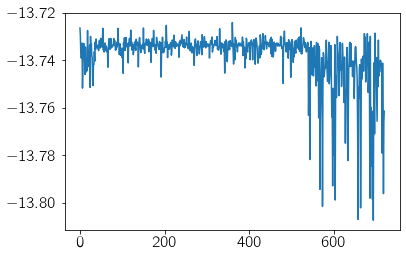

In [54]:
plt.plot(np.log10(np.abs(mu_mapMID**2*contrast_check_MID)))

In [55]:
HI_mode_rms_v1 = np.zeros(n_HI)
HI_mode_rms_v2 = np.zeros(n_HI)
contrast_check_HI = np.zeros(n_HI)
seg_counter = 0
for pp in range(0,n_HI):
    current_seg = seg_evaluated[seg_counter]
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    input_wf = luvoir.wf_aper
    HI_modes[pp] = eunit / 2
    luvoir.fm.actuators  = HI_modes
    tmp_pupil = luvoir.fm(input_wf)
    wavefront_map_tmp = tmp_pupil.phase/tmp_pupil.wavenumber*luvoir.aper
    HI_mode_rms_v1[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    wavefront_map_tmp = luvoir.fm.opd*luvoir.aper
    HI_mode_rms_v2[pp] = np.sqrt(np.sum(wavefront_map_tmp**2)/np.sum(luvoir.aper))
    psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
    dh_intensity = psf/norm * dh_mask
    test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)]) - contrast_floor
    contrast_check_HI[pp] = test_contrast

In [56]:
np.sum(mu_mapHI**2*contrast_check_HI)

1.3100835437740548e-11

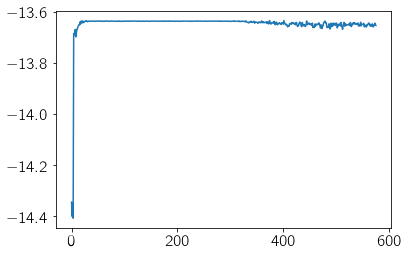

In [57]:
plt.plot(np.log10(np.abs(mu_mapHI**2*contrast_check_HI)))

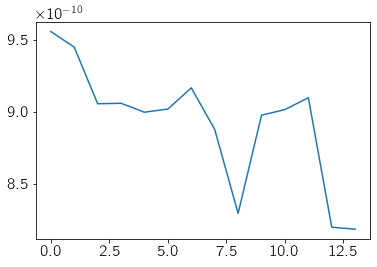

In [579]:
plt.plot(LO_mode_rms_v2)

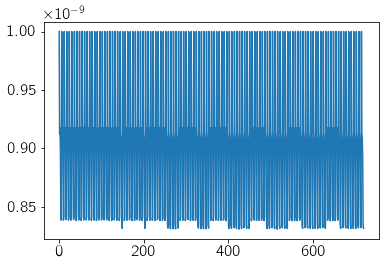

In [580]:
plt.plot(MID_mode_rms_v2)

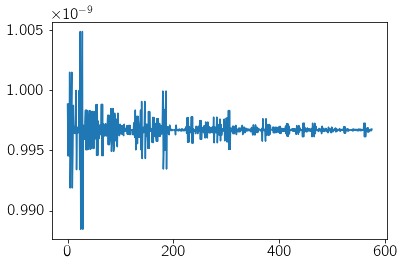

In [581]:
plt.plot(HI_mode_rms_v2)

In [58]:
# fig, ax = plt.subplots(ncols=1)
# img1 = hc.imshow_field(nu_maps[0]/eunit*1000, cmap='RdBu')#, vmin=pmin, vmax=pmax)
# clb = fig.colorbar(img1)
# clb.set_label('pm', rotation=90)
# plt.tight_layout(h_pad=1)
# plt.title('Segment Level Piston ')
# zernike_coeffs = zernike_coeffs_numaps[0]*eunit/2
# luvoir.sm.actuators = zernike_coeffs
# luvoir.sm(luvoir.wf_aper)
# psf, ref = luvoir.calc_psf(ref=True, return_intermediate='False')
# plt.figure(figsize=(10, 10))
# hc.imshow_field(psf/norm, norm=LogNorm())
# plt.colorbar()
# dh_intensity = psf/norm * dh_mask
# test_contrast = np.mean(dh_intensity[np.where(dh_intensity != 0)])- baseline_contrast
# print('contrast:', test_contrast)

# Making basic figures for the paper 

## Checking if the matrix works for LO and MID modes, not doing the other ones. Bottom line it works but does not include the phi^2 term in the taylor expansion of the phase

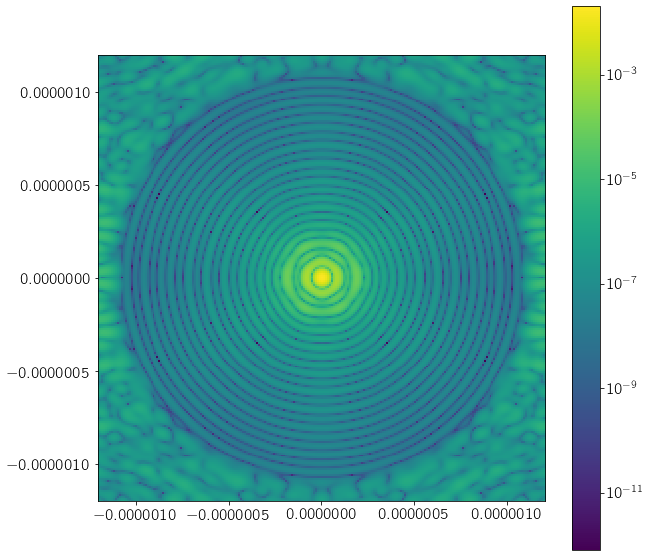

In [59]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)
plt.figure(figsize=(10, 10))
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()

In [582]:
grid_test = hc.make_focal_grid(
            luvoir.sampling,
            luvoir.imlamD,
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
nyquist_sampling = 2.
grid_det_subsample = hc.make_focal_grid(
            nyquist_sampling,
            np.floor(luvoir.imlamD),
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
### Dark hole mask
dh_outer_nyquist = hc.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_inner_nyquist = hc.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_mask_nyquist = (dh_outer_nyquist - dh_inner_nyquist).astype('bool')
tmp = hc.interpolation.make_linear_interpolator_separated(ref, grid=grid_test)
ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
norm_nyquist = np.max(ref_nyquist)
poil = hc.interpolation.make_linear_interpolator_separated(unaberrated_coro_psf, grid=grid_test)
test = (luvoir.sampling/nyquist_sampling)**2*poil(grid_det_subsample)

In [583]:
norm_nyquist

Field(0.08121914)

In [584]:
norm

Field(0.02030479)

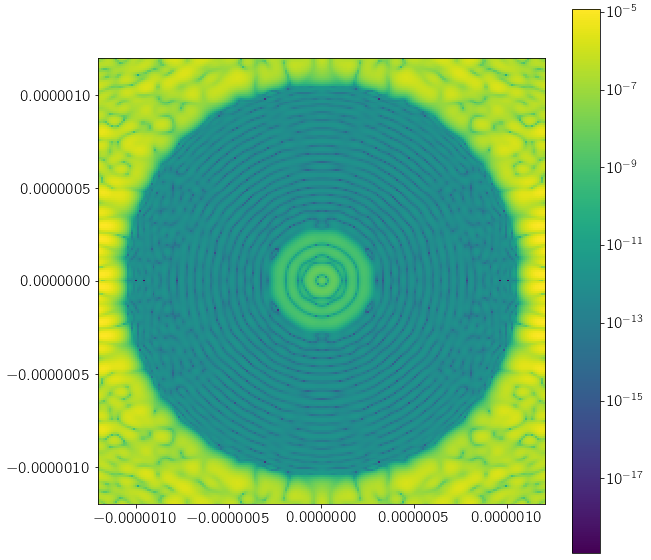

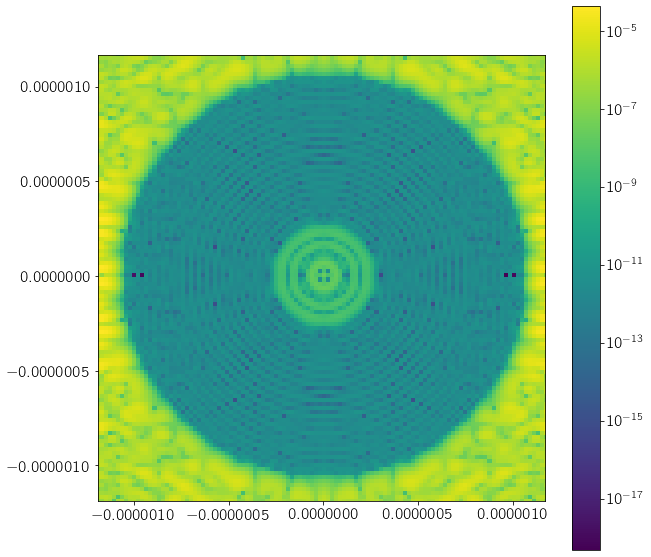

In [585]:
plt.figure(figsize=(10, 10))
hc.imshow_field(unaberrated_coro_psf,norm=LogNorm())
plt.colorbar()
plt.figure(figsize=(10, 10))
hc.imshow_field(test,norm=LogNorm())
plt.colorbar()

In [66]:
print(np.mean(unaberrated_coro_psf[np.where(dh_mask != 0)])/norm)

3.92482266388378e-11


In [67]:
print(np.mean(test[np.where(dh_mask_nyquist != 0)])/norm_nyquist)

3.9206600960950376e-11


In [629]:
QLO = np.diag(np.asarray(mu_mapLO**2))
QMID = np.diag(np.asarray(mu_mapMID**2))
QHI = np.diag(np.asarray(mu_mapHI**2))
QHI_Fudged = np.diag(np.asarray(mu_mapHI_Fudged**2))

In [69]:
### Dark hole mask
# dh_outer = hc.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(luvoir.focal_det)
# dh_inner = hc.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(luvoir.focal_det)
# dh_mask = (dh_outer - dh_inner).astype('bool')

8.108057686774238e-15
8.072183869857172e-15


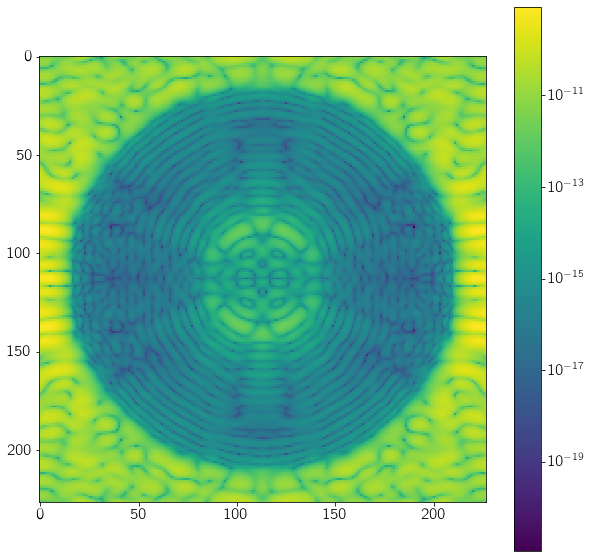

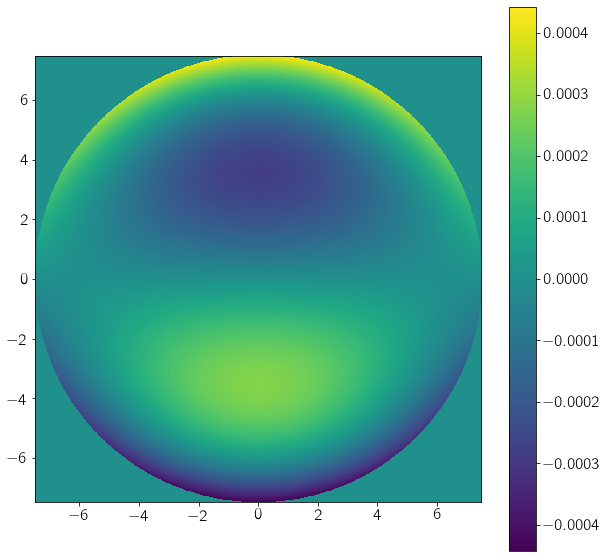

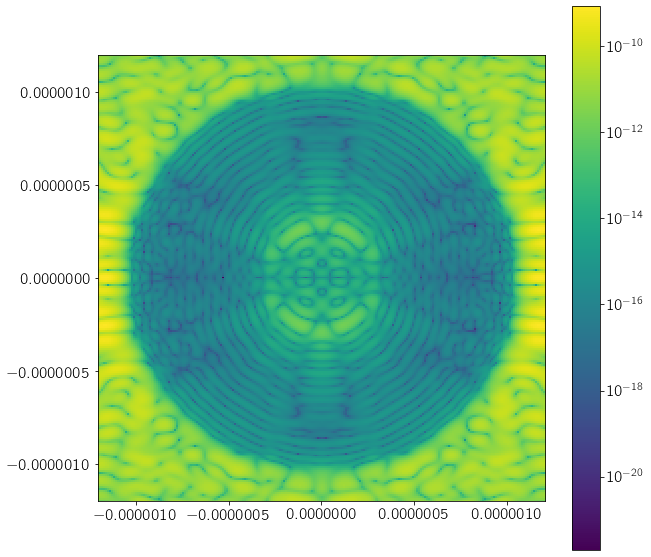

In [70]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter['at_science_focus'].electric_field
# LO_modes[1:n_LO] = np.random.multivariate_normal(np.zeros(n_LO-1),QLO)
LO_modes[6] = 0.1
G_coron_LOAll = G_LO_real + 1j*G_LO_imag - Efield_ref
# test = np.dot(LO_modes,G_coron_LOAll) + Efield_ref
test = np.dot(LO_modes,G_coron_LOAll) 
test_int = np.reshape(np.abs(test)**2,[227,227])
plt.figure(figsize=(10, 10))
plt.imshow(test_int/norm, norm=LogNorm())
plt.colorbar()
luvoir.zm.actuators = LO_modes*eunit/2
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
plt.figure(figsize=(10, 10))
hc.imshow_field(luvoir.zm.opd/luvoir.wvln)
plt.colorbar()
aberrated_coro_psf, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
plt.figure(figsize=(10, 10))
trou = np.abs(inter['at_science_focus'].electric_field - Efield_ref )**2
hc.imshow_field(trou/norm, norm=LogNorm())
plt.colorbar()
test1 = np.reshape(trou/norm,[227,227])
test2 = test_int/norm
dh_intensity = np.reshape(test2,227**2)* dh_mask
print(np.mean(dh_intensity[np.where(dh_mask != 0)]))
dh_intensity = (trou/norm) * dh_mask
print(np.mean(dh_intensity[np.where(dh_mask != 0)]))

5.749732121475463e-08
5.707515749487027e-08


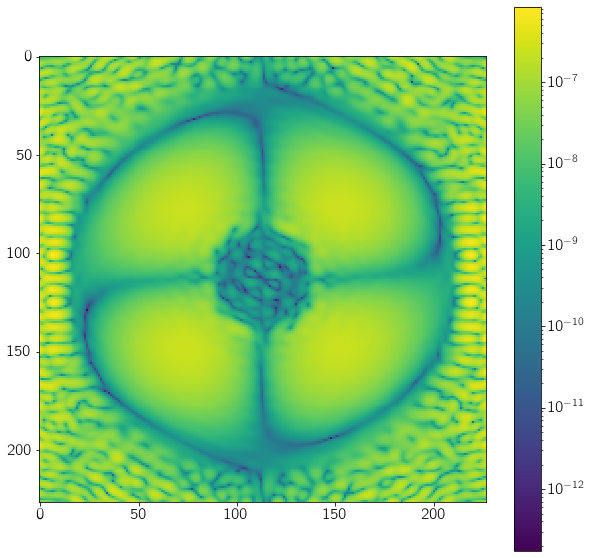

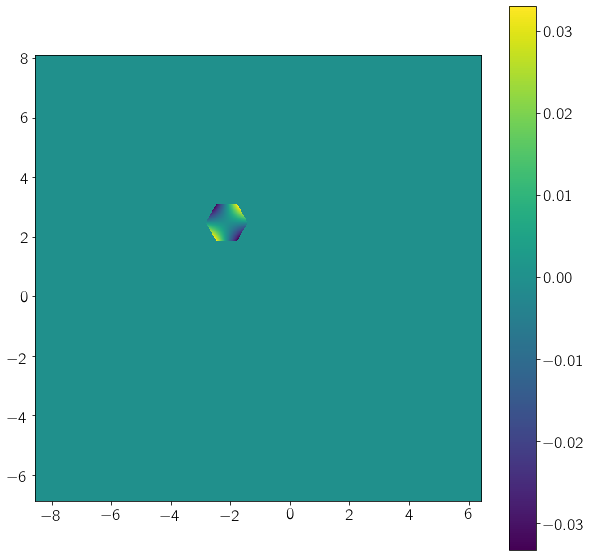

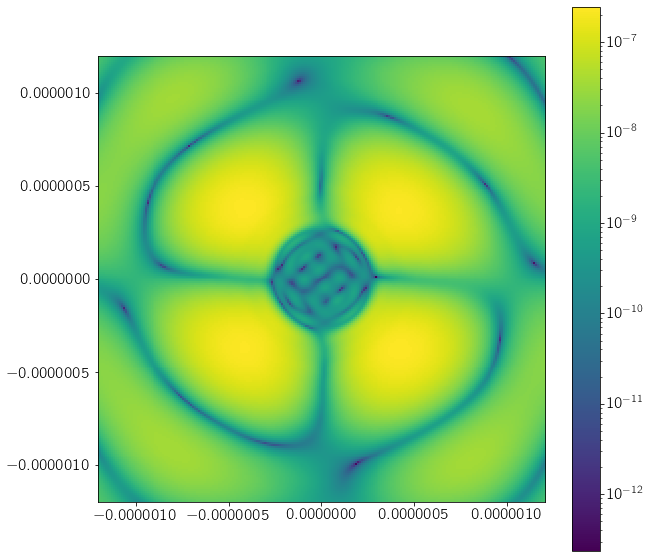

In [71]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter['at_science_focus'].electric_field
# LO_modes[1:n_LO] = np.random.multivariate_normal(np.zeros(n_LO-1),QLO)
MID_modes[70] = 10
G_coron_MIDAll = G_MID_real + 1j*G_MID_imag - Efield_ref
# test = np.dot(LO_modes,G_coron_LOAll) + Efield_ref
test = np.dot(MID_modes,G_coron_MIDAll) 
test_int = np.reshape(np.abs(test)**2,[227,227])
plt.figure(figsize=(10, 10))
plt.imshow(test_int/norm, norm=LogNorm())
plt.colorbar()
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes*eunit/2
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
plt.figure(figsize=(10, 10))
hc.imshow_field(luvoir.sm.opd/luvoir.wvln)
plt.colorbar()
aberrated_coro_psf, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
plt.figure(figsize=(10, 10))
trou = np.abs(inter['at_science_focus'].electric_field - Efield_ref )**2
hc.imshow_field(trou/norm, norm=LogNorm())
plt.colorbar()
test1 = np.reshape(trou/norm,[227,227])
test2 = test_int/norm
dh_intensity = np.reshape(test2,227**2)* dh_mask
print(np.mean(dh_intensity[np.where(dh_mask != 0)]))
dh_intensity = (trou/norm) * dh_mask
print(np.mean(dh_intensity[np.where(dh_mask != 0)]))

# Make pictures of modes and stuff 

In [72]:
zernike_ref = luvoir.prop_LOWFS()

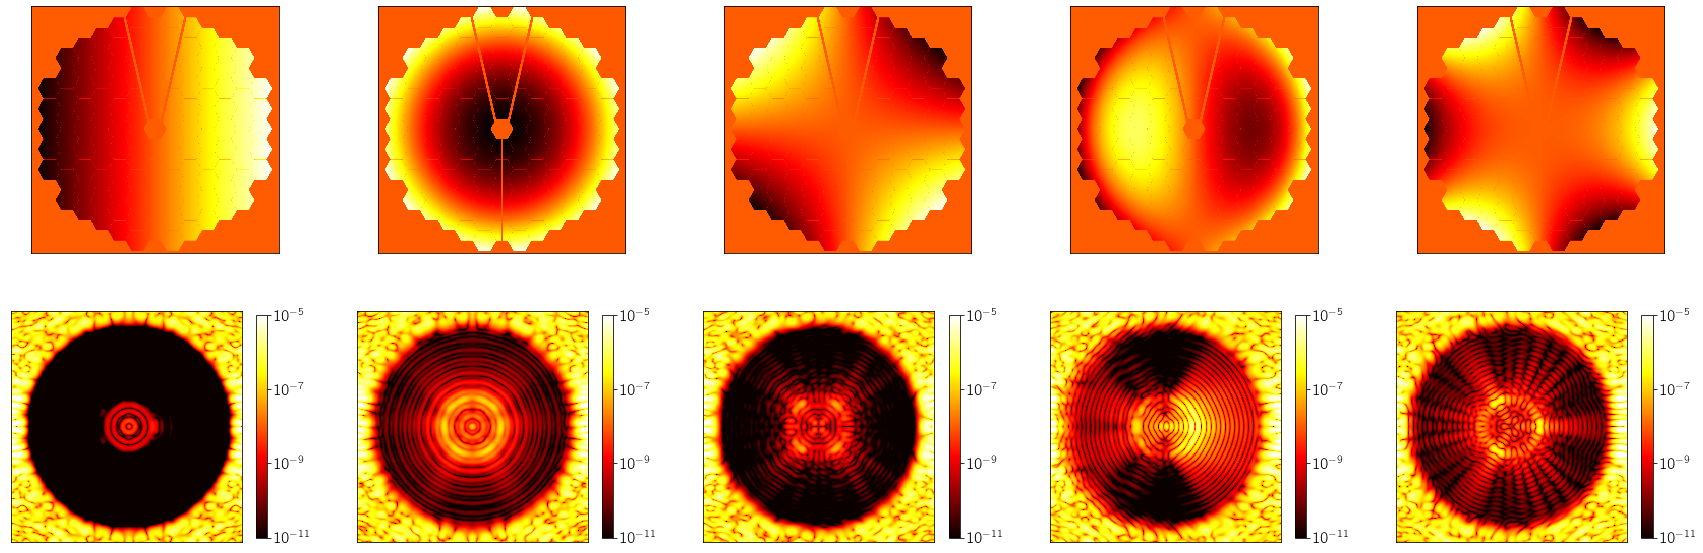

In [586]:
poked_modes = [1,3,4,7,9]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    LO_modes[poked_modes[pp]] = eunit/2*100
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.zm.surface
    tmp_psf_poke, ref, = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
    detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(2, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[0,qq].imshow(phases[qq],cmap = 'hot')
    axs[0,qq].axes.get_xaxis().set_visible(False)
    axs[0,qq].axes.get_yaxis().set_visible(False)
    psfplot =  axs[1,qq].imshow(detectors[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-5),cmap = 'hot')
    fig.colorbar(psfplot,ax = axs[1,qq],shrink=0.9)
    axs[1,qq].axes.get_xaxis().set_visible(False)
    axs[1,qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'LO_modes_DH_display' + '.pdf'
fig.savefig(file_name)

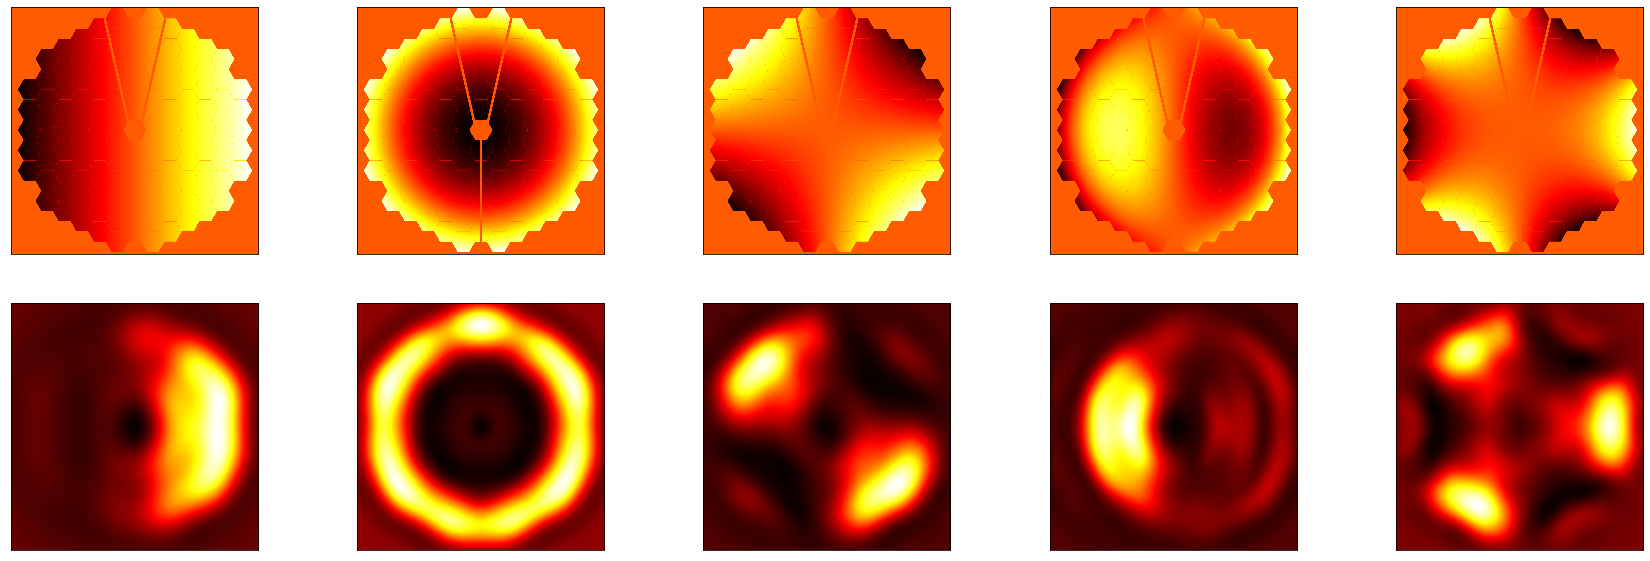

In [587]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
zernike_ref = luvoir.prop_LOWFS()
poked_modes = [1,3,4,7,9]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),npup,npup])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    LO_modes[poked_modes[pp]] = eunit/2*100
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.zm.surface
    tmp_psf_poke = luvoir.prop_LOWFS()
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
    detectors[pp] = np.reshape(tmp_psf_poke.power - zernike_ref.power,[npup,npup])
fig, axs = plt.subplots(2, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[0,qq].imshow(phases[qq],cmap = 'hot')
    axs[0,qq].axes.get_xaxis().set_visible(False)
    axs[0,qq].axes.get_yaxis().set_visible(False)
    psfplot =  axs[1,qq].imshow(detectors[qq],cmap = 'hot')
#     fig.colorbar(psfplot,ax = axs[1,qq],shrink=0.9)
    axs[1,qq].axes.get_xaxis().set_visible(False)
    axs[1,qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'LO_modes_LOWFS_display' + '.pdf'
fig.savefig(file_name)

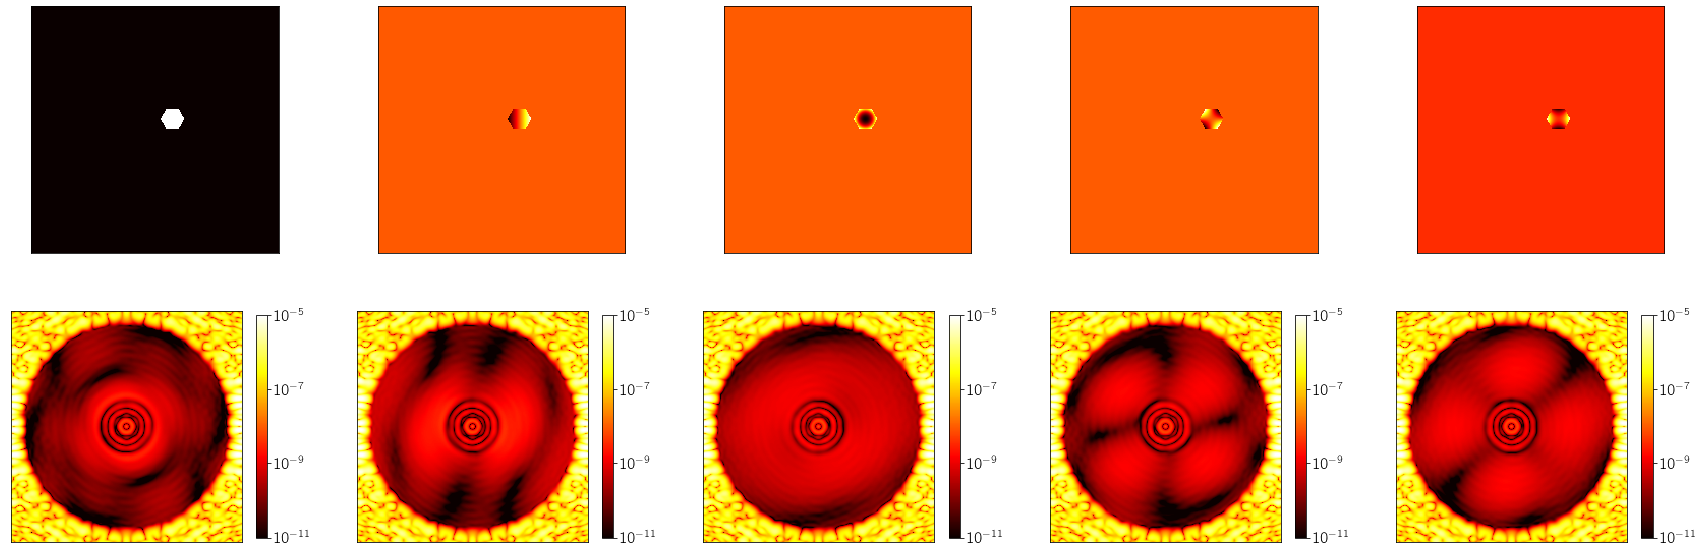

In [588]:
poked_modes = [0,1,3,4,5]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    MID_modes[poked_modes[pp]] = eunit/2*10
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.sm.surface
    tmp_psf_poke, ref, = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
    phases[pp] = np.reshape(tmp_surface_poke,[npup,npup])
    detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(2, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[0,qq].imshow(phases[qq],cmap = 'hot')
    axs[0,qq].axes.get_xaxis().set_visible(False)
    axs[0,qq].axes.get_yaxis().set_visible(False)
    psfplot =  axs[1,qq].imshow(detectors[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-5),cmap = 'hot')
    fig.colorbar(psfplot,ax = axs[1,qq],shrink=0.9)
    axs[1,qq].axes.get_xaxis().set_visible(False)
    axs[1,qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'MID_modes_DH_display' + '.pdf'
fig.savefig(file_name)

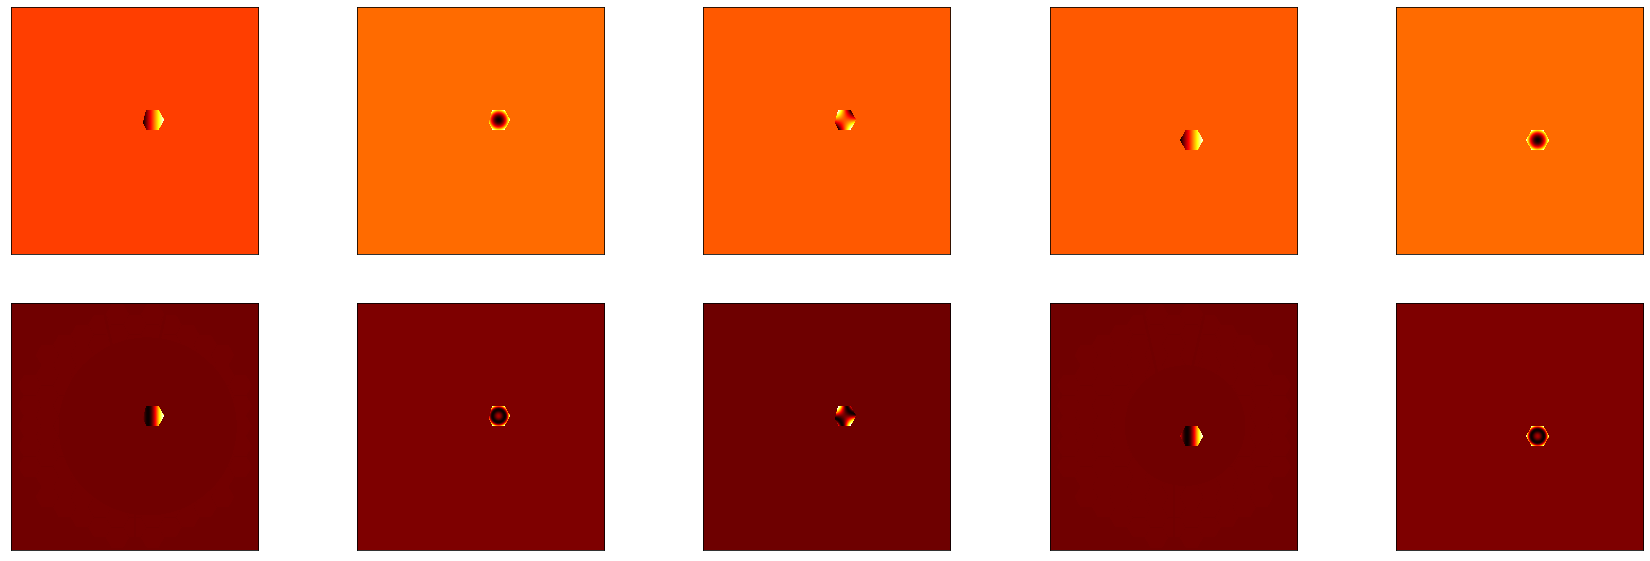

In [590]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
zernike_ref = luvoir.prop_OBWFS()
poked_modes = [1,3,4,7,9]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),npup,npup])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    MID_modes[poked_modes[pp]] = eunit/2*100
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.sm.surface
    tmp_psf_poke = luvoir.prop_OBWFS()
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
    detectors[pp] = np.reshape(tmp_psf_poke.power - zernike_ref.power,[npup,npup])
fig, axs = plt.subplots(2, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[0,qq].imshow(phases[qq],cmap = 'hot')
    axs[0,qq].axes.get_xaxis().set_visible(False)
    axs[0,qq].axes.get_yaxis().set_visible(False)
    psfplot =  axs[1,qq].imshow(detectors[qq],cmap = 'hot')
#     fig.colorbar(psfplot,ax = axs[1,qq],shrink=0.9)
    axs[1,qq].axes.get_xaxis().set_visible(False)
    axs[1,qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'MID_modes_OBWFS_display' + '.pdf'
fig.savefig(file_name)

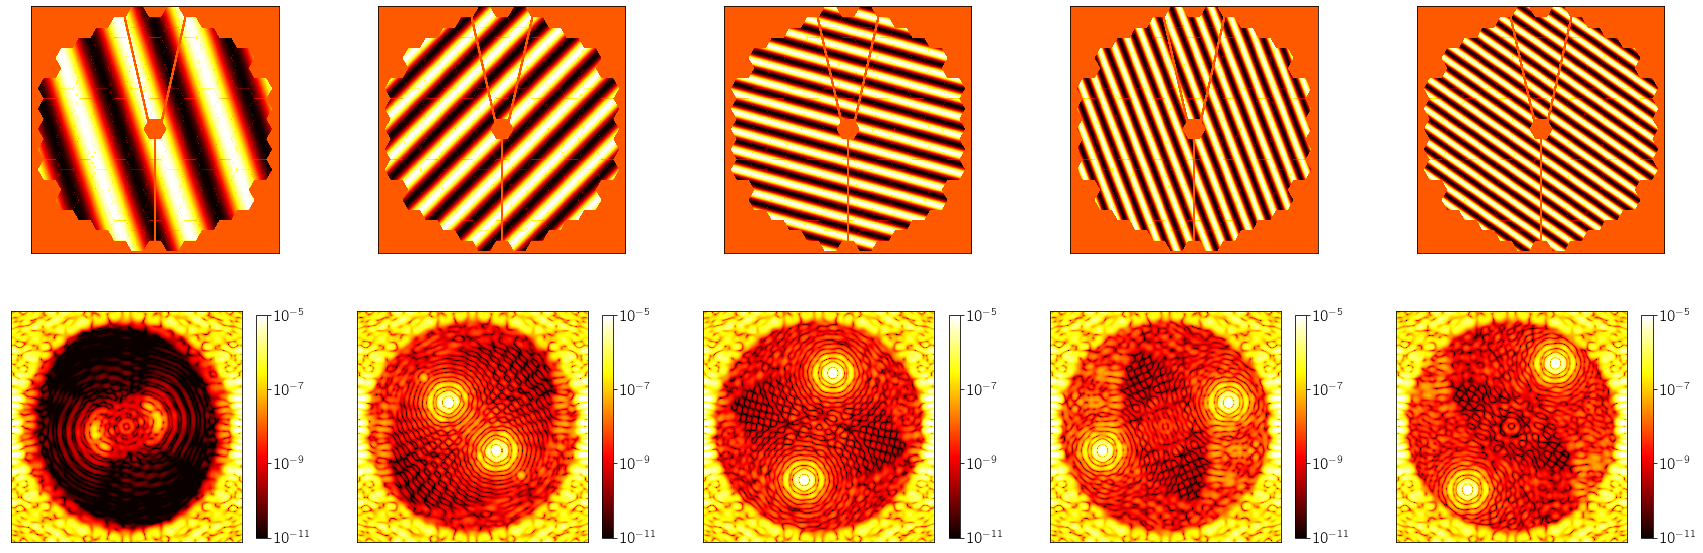

In [591]:
poked_modes = [10,32,101,154,203]
n_pokes = len(poked_modes)
phases = np.zeros([len(poked_modes),npup,npup])
detectors = np.zeros([len(poked_modes),227,227])
for pp in range(0,n_pokes):
    LO_modes = np.zeros(n_LO)
    MID_modes = np.zeros(n_MID)
    HI_modes = np.zeros(n_HI)
    DM_modes = np.zeros(n_DM)
    HI_modes[poked_modes[pp]] = eunit/2*10
    luvoir.zm.actuators = LO_modes
    luvoir.sm.actuators = MID_modes
    luvoir.fm.actuators = HI_modes
    luvoir.dm.actuators = DM_modes
    tmp_surface_poke = luvoir.fm.surface
    tmp_psf_poke, ref, = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
    phases[pp] = np.reshape(tmp_surface_poke*luvoir.aper,[npup,npup])
    detectors[pp] = np.reshape(tmp_psf_poke,[227,227])
fig, axs = plt.subplots(2, n_pokes,figsize=(30,10))
for qq in range(0,n_pokes):
    phaseplot = axs[0,qq].imshow(phases[qq],cmap = 'hot')
    axs[0,qq].axes.get_xaxis().set_visible(False)
    axs[0,qq].axes.get_yaxis().set_visible(False)
    psfplot =  axs[1,qq].imshow(detectors[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-5),cmap = 'hot')
    fig.colorbar(psfplot,ax = axs[1,qq],shrink=0.9)
    axs[1,qq].axes.get_xaxis().set_visible(False)
    axs[1,qq].axes.get_yaxis().set_visible(False)
plt.show()
file_name = 'HI_modes_DH_display' + '.pdf'
fig.savefig(file_name)

## running matrix based MC

In [592]:
from time import time

In [593]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref, inter = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter['at_science_focus'].electric_field
G_coron_LOAll = G_LO_real + 1j*G_LO_imag - Efield_ref
G_coron_MIDAll = G_MID_real + 1j*G_MID_imag - Efield_ref
G_coron_HIAll = G_HI_real + 1j*G_HI_imag - Efield_ref

In [594]:
var_outer = hc.circular_aperture(2 * (luvoir.apod_dict[design]['iwa'] + 2 ) * luvoir.lam_over_d)(luvoir.focal_det)
var_inner = hc.circular_aperture(2 * (luvoir.apod_dict[design]['iwa'] + 1 ) * luvoir.lam_over_d)(luvoir.focal_det)
var_mask = (var_outer - var_inner).astype('bool')

In [630]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
n_trial = 100
wavefront_rms = np.zeros(n_trial)
for pp in range(1,n_trial):
    LO_modes[1:n_LO] = np.random.multivariate_normal(np.zeros(n_LO-1),QLO)*eunit/2
    luvoir.zm.actuators = LO_modes
    wavefront_rms[pp] = np.sum(luvoir.zm.surface**2*luvoir.aper)/np.sum(luvoir.aper)
wLO_11 = np.median(np.sqrt(wavefront_rms))
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
n_trial = 100
wavefront_rms = np.zeros(n_trial)
for pp in range(1,n_trial):
    MID_modes = np.random.multivariate_normal(np.zeros(n_MID),QMID)*eunit/2
    luvoir.sm.actuators = MID_modes
    wavefront_rms[pp] = np.sum(luvoir.sm.surface**2*luvoir.aper)/np.sum(luvoir.aper)
wMID_11 = np.median(np.sqrt(wavefront_rms))
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
n_trial = 100
wavefront_rms = np.zeros(n_trial)
for pp in range(1,n_trial):
    HI_modes = np.random.multivariate_normal(np.zeros(n_HI),QHI_Fudged)*eunit/2
    luvoir.fm.actuators = HI_modes
    wavefront_rms[pp] = np.sum(luvoir.fm.surface**2*luvoir.aper)/np.sum(luvoir.aper)
wHI_11 = np.median(np.sqrt(wavefront_rms))

In [631]:
wLO_11

7.551226934849972e-09

In [632]:
wMID_11

1.092053096911512e-11

In [633]:
wHI_11

4.450331669357067e-12

0.03162277660168379
0.04124626382901352
0.05379838403443687
0.07017038286703829
0.09152473108773893
0.11937766417144367
0.1557068404753731
0.20309176209047358
0.2648969287610528
0.345510729459222
0.4506570337745475
0.5878016072274915
0.7666822074546215
1.0
1.3043213867190053
1.7012542798525891
2.2189823414589718
2.8942661247167516
3.7750532053243955
4.923882631706742
6.422325422229362
8.376776400682925
10.92600861117379
14.251026703029993
18.587918911465636
24.244620170823282
31.622776601683793
41.24626382901352
53.79838403443687
70.1703828670383
91.52473108773893
119.3776641714437
155.70684047537316
203.09176209047368
264.89692876105295
345.5107294592218
450.65703377454776
587.8016072274912
766.6822074546222
1000.0
5.3531529903411865


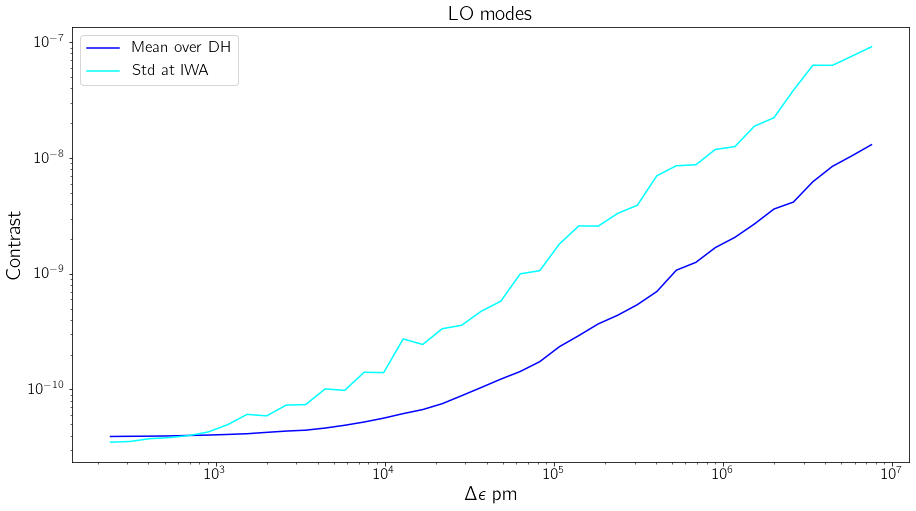

In [852]:
n_trial = 90
Nwavescale = 40
WaveScaleMinus = -1.5
WaveScalePlus = 3
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
tic = time()
qq = 0
for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
    print(wavescale)
    for pp in range(1,n_trial):
        LO_modes[1:n_LO] = np.random.multivariate_normal(np.zeros(n_LO-1),wavescale*QLO)
        luvoir.zm.actuators = LO_modes
        tmp0 = np.abs(np.dot(LO_modes,G_coron_LOAll) + Efield_ref)**2
        tmp1 = tmp0/norm
        dh_intensity_stack[qq,pp] = np.mean(tmp1[np.where(dh_mask != 0)])
        dh_var_stack[qq,pp] = np.std(tmp1[np.where(var_mask != 0)])
    qq = qq + 1
toc = time()
print(toc - tic)
wave_vec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)*wLO_11*10**(12)
contrast_wavefront = np.mean(dh_intensity_stack,1)
scatter_contrast_wavefront = np.max(dh_var_stack,1)
fig = plt.figure(figsize=(15, 8))
plt.plot(wave_vec,contrast_wavefront,label='Mean over DH',linewidth=1.5,color = 'blue')
plt.plot(wave_vec,scatter_contrast_wavefront, label='Std at IWA',linewidth=1.5,color = 'cyan')
plt.semilogy()
plt.semilogx()
plt.title('LO modes', size=20)
plt.xlabel('$\Delta \epsilon$ pm', size=20)
plt.ylabel('Contrast', size=20)
plt.legend()
file_name = 'LO_modes_hockeystick' + '.pdf'
fig.savefig(file_name)

0.03162277660168379
0.04124626382901352
0.05379838403443687
0.07017038286703829
0.09152473108773893
0.11937766417144367
0.1557068404753731
0.20309176209047358
0.2648969287610528
0.345510729459222
0.4506570337745475
0.5878016072274915
0.7666822074546215
1.0
1.3043213867190053
1.7012542798525891
2.2189823414589718
2.8942661247167516
3.7750532053243955
4.923882631706742
6.422325422229362
8.376776400682925
10.92600861117379
14.251026703029993
18.587918911465636
24.244620170823282
31.622776601683793
41.24626382901352
53.79838403443687
70.1703828670383
91.52473108773893
119.3776641714437
155.70684047537316
203.09176209047368
264.89692876105295
345.5107294592218
450.65703377454776
587.8016072274912
766.6822074546222
1000.0
156.6483678817749


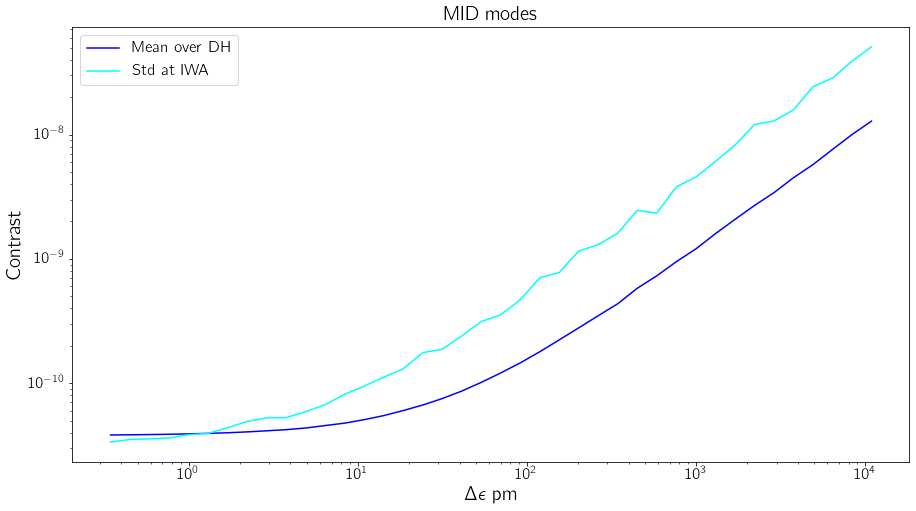

In [856]:
n_trial = 30
Nwavescale = 40
WaveScaleMinus = -1.5
WaveScalePlus = 3
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
tic = time()
qq = 0
for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
    print(wavescale)
    for pp in range(1,n_trial):
        MID_modes = np.random.multivariate_normal(np.zeros(n_MID),wavescale*QMID)
        luvoir.sm.actuators = MID_modes
        tmp0 = np.abs(np.dot(MID_modes,G_coron_MIDAll) + Efield_ref)**2
        tmp1 = tmp0/norm
        dh_intensity_stack[qq,pp] = np.mean(tmp1[np.where(dh_mask != 0)])
        dh_var_stack[qq,pp] = np.std(tmp1[np.where(var_mask != 0)])
    qq = qq + 1
toc = time()
print(toc - tic)
wave_vec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)*wMID_11*10**(12)
contrast_wavefront = np.mean(dh_intensity_stack,1)
scatter_contrast_wavefront = np.max(dh_var_stack,1)
fig = plt.figure(figsize=(15, 8))
plt.plot(wave_vec,contrast_wavefront,label='Mean over DH',linewidth=1.5,color = 'blue')
plt.plot(wave_vec,scatter_contrast_wavefront, label='Std at IWA',linewidth=1.5,color = 'cyan')
plt.semilogy()
plt.semilogx()
plt.title('MID modes', size=20)
plt.xlabel('$\Delta \epsilon$ pm', size=20)
plt.ylabel('Contrast', size=20)
plt.legend()
file_name = 'MID_modes_hockeystick' + '.pdf'
fig.savefig(file_name)

0.03162277660168379
0.04124626382901352
0.05379838403443687
0.07017038286703829
0.09152473108773893
0.11937766417144367
0.1557068404753731
0.20309176209047358
0.2648969287610528
0.345510729459222
0.4506570337745475
0.5878016072274915
0.7666822074546215
1.0
1.3043213867190053
1.7012542798525891
2.2189823414589718
2.8942661247167516
3.7750532053243955
4.923882631706742
6.422325422229362
8.376776400682925
10.92600861117379
14.251026703029993
18.587918911465636
24.244620170823282
31.622776601683793
41.24626382901352
53.79838403443687
70.1703828670383
91.52473108773893
119.3776641714437
155.70684047537316
203.09176209047368
264.89692876105295
345.5107294592218
450.65703377454776
587.8016072274912
766.6822074546222
1000.0
80.04163694381714


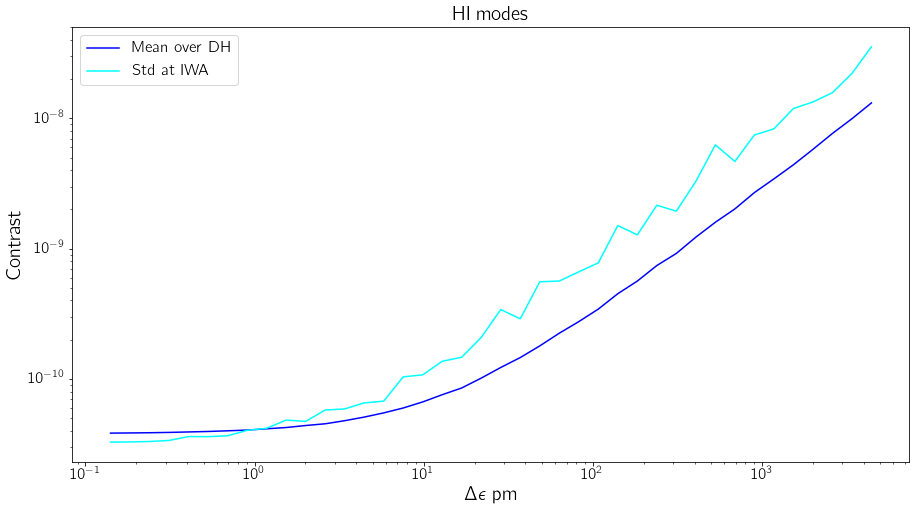

In [857]:
n_trial = 30
Nwavescale = 40
WaveScaleMinus = -1.5
WaveScalePlus = 3
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
tic = time()
qq = 0
for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
    print(wavescale)
    for pp in range(1,n_trial):
        HI_modes = np.random.multivariate_normal(np.zeros(n_HI),wavescale*QHI)
        luvoir.fm.actuators = HI_modes
        tmp0 = np.abs(np.dot(HI_modes,G_coron_HIAll) + Efield_ref)**2
        tmp1 = tmp0/norm
        dh_intensity_stack[qq,pp] = np.mean(tmp1[np.where(dh_mask != 0)])
        dh_var_stack[qq,pp] = np.std(tmp1[np.where(var_mask != 0)])
    qq = qq + 1
toc = time()
print(toc - tic)
wave_vec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)*wHI_11*10**(12)
contrast_wavefront = np.mean(dh_intensity_stack,1)
scatter_contrast_wavefront = np.max(dh_var_stack,1)
fig = plt.figure(figsize=(15, 8))
plt.plot(wave_vec,contrast_wavefront,label='Mean over DH',linewidth=1.5,color = 'blue')
plt.plot(wave_vec,scatter_contrast_wavefront, label='Std at IWA',linewidth=1.5,color = 'cyan')
plt.semilogy()
plt.semilogx()
plt.title('HI modes', size=20)
plt.xlabel('$\Delta \epsilon$ pm', size=20)
plt.ylabel('Contrast', size=20)
plt.legend()
file_name = 'HI_modes_hockeystick' + '.pdf'
fig.savefig(file_name)

In [91]:
# n_trial = 30
# Nwavescale = 40
# WaveScaleMinus = -1.5
# WaveScalePlus = 3
# LO_modes = np.zeros(n_LO)
# MID_modes = np.zeros(n_MID)
# HI_modes = np.zeros(n_HI)
# DM_modes = np.zeros(n_DM)
# luvoir.zm.actuators = LO_modes
# luvoir.sm.actuators = MID_modes
# luvoir.fm.actuators = HI_modes
# luvoir.dm.actuators = DM_modes
# image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
# dh_intensity_stack = np.zeros([Nwavescale,n_trial])
# dh_var_stack = np.zeros([Nwavescale,n_trial])
# tic = time()
# qq = 0
# for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
#     print(wavescale)
#     for pp in range(1,n_trial):
#         LO_modes[1:N_LO] = np.random.multivariate_normal(np.zeros(N_LO-1),wavescale*QLO)
#         luvoir.zm.actuators = LO_modes
#         tmp0 = np.abs(np.dot(LO_modes,G_coron_LOAll) + Efield_ref)**2
#         tmp1 = tmp0/norm
#         dh_intensity_stack[qq,pp] = np.mean(tmp1[np.where(dh_mask != 0)])
#         dh_var_stack[qq,pp] = np.std(tmp1[np.where(var_mask != 0)])
#     qq = qq + 1
# toc = time()
# print(toc - tic)
# wave_vec = np.logspace(WaveScaleMinus*10**(-12),WaveScalePlus,Nwavescale)*wLO_11
# contrast_wavefront = np.mean(dh_intensity_stack,1)
# scatter_contrast_wavefront = np.max(dh_var_stack,1)
# plt.figure(figsize=(15, 8))
# plt.plot(wave_vec,contrast_wavefront,label='Mean over DH')
# plt.plot(wave_vec,scatter_contrast_wavefront, label='Std at IWA')
# plt.semilogy()
# plt.semilogx()
# plt.title('LO modes', size=20)
# plt.xlabel('$\Delta \epsilon$ pm', size=20)
# plt.ylabel('Contrast', size=20)
# plt.legend()

In [944]:
fudge_core = 2.
Nph = fudge_core*2.052e09*luvoir.wvln/eunit*0.1
t_long = 3600

In [945]:
fudge_core = 4.
Nph2 = fudge_core*2.052e09*luvoir.wvln/eunit*0.3
t_long = 3600

In [946]:
2.5*np.log10(Nph2/Nph)

1.9453781259591092

5.289511571544166e-12


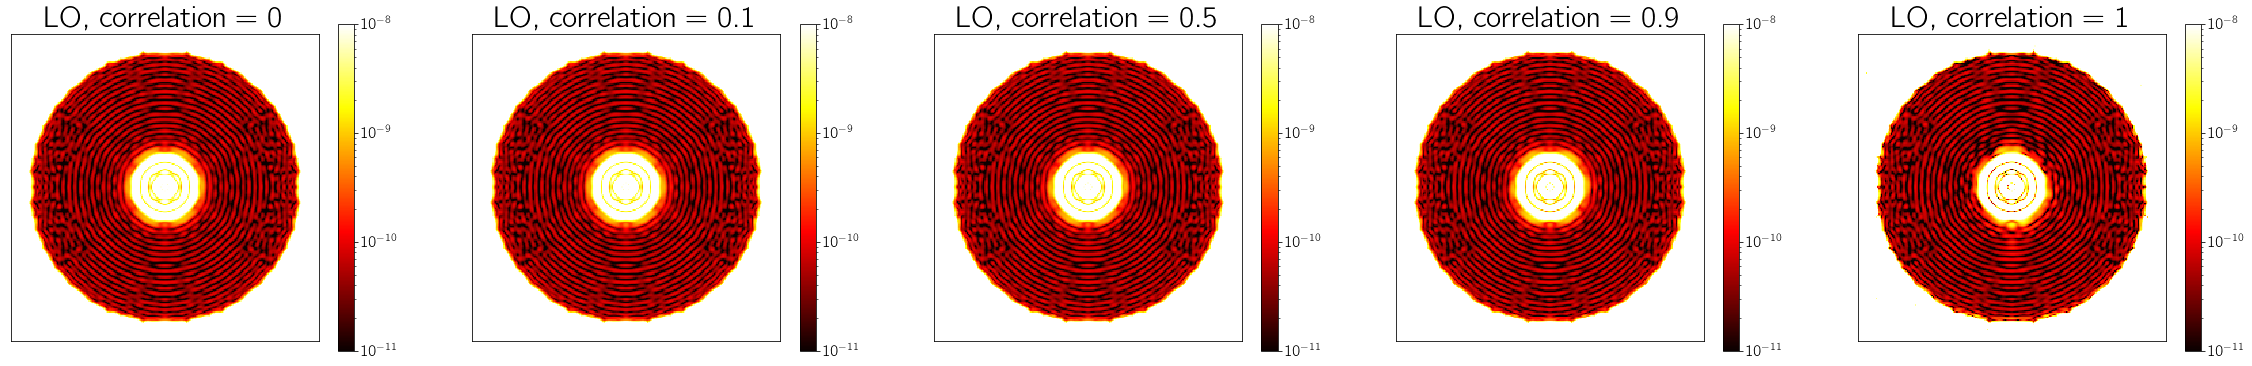

In [859]:
n_trial = 100
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
wavescale = 1.
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
LO_modes[1:n_LO] = np.random.multivariate_normal(np.zeros(n_LO-1),wavescale*QLO)
corr_vec = [0,0.1,0.5,0.9,1]
n_corr = len(corr_vec)
image_stack = np.zeros([n_corr,n_trial, Efield_ref.shape[0]])
for qq in range(0,n_corr):
    corr = corr_vec[qq]
    for pp in range(0,n_trial):
        LO_modes[1:n_LO] = corr*LO_modes[1:n_LO] + np.sqrt(1-corr**2)*np.random.multivariate_normal(np.zeros(n_LO-1),wavescale*QLO)
        tmp0 = np.abs(np.dot(LO_modes,G_coron_LOAll) + Efield_ref)**2
        image_stack[qq,pp] = tmp0/norm
mean_img_s = np.reshape(np.mean(image_stack,1),[5,227,227])
fig, axs = plt.subplots(1, n_corr,figsize=(40, 10))
for qq in range(0,n_corr):
    pcm =  axs[qq].imshow(mean_img_s[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-8),cmap = 'hot')
    fig.colorbar(pcm,ax = axs[qq],shrink=0.6)
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
    axs[qq].set_title('LO, correlation = ' + np.str(corr_vec[qq]), size=30)
decorr_im = np.abs(np.mean(image_stack[0],0) - np.abs(Efield_ref)**2/norm)
decorr_im_shot_1phot = np.sqrt(norm*decorr_im)/norm
print(np.mean(decorr_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))
# file_name = 'LO_modes_DH_corr' + '.pdf'
# fig.savefig(file_name)

In [864]:
mean_img_s_line = np.reshape(mean_img_s,[5,227*227])
raw_cont = np.mean(mean_img_s_line[0][np.where(dh_mask != 0)])
test_im = np.abs(mean_img_s_line[0] - np.abs(Efield_ref)**2/norm)
#test_im = np.abs(mean_img_s_line[4])
test_im_shot_1phot = np.sqrt(norm*test_im)/norm
print(np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))
LO_halo_contrast_photons = np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long)
test_im = np.abs(mean_img_s_line[4] - np.abs(Efield_ref)**2/norm)
print(np.mean(test_im[np.where(dh_mask != 0)]))
LO_speckles_contrast = np.mean(test_im[np.where(dh_mask != 0)])

5.289511571544166e-12
1.720080941799793e-11


In [865]:
Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 12
WaveScaleMinus = -2
WaveScalePlus = 2
Nflux = 3
fluxPlus = 10
fluxMinus = 0
NiterBatch = 20
NiterRecursive = 100
timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

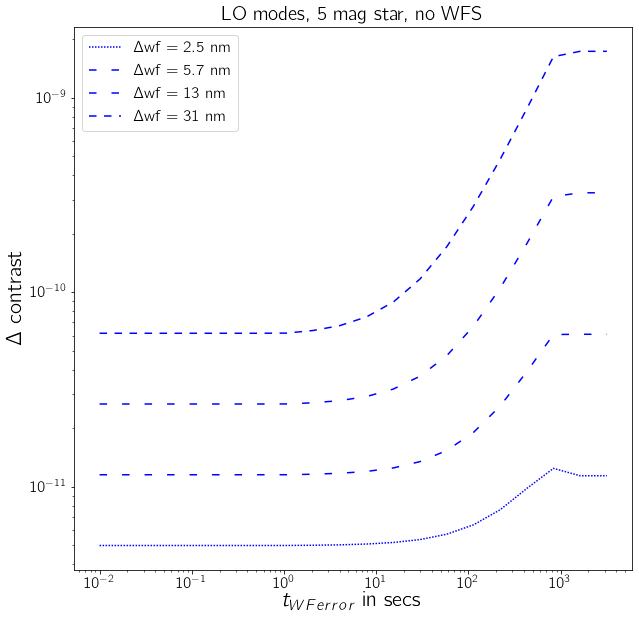

In [866]:
def average_LO(tscale,wavescale,StarMag):
    Starfactor = 10**(-StarMag/2.5)
    if tscale < 1:
        tmp_alpha = 0
    elif tscale > t_long/4:
        tmp_alpha = 1
    else:
        tmp_alpha = (tscale - 1)/t_long*4
    tmp_photons = wavescale*LO_halo_contrast_photons/np.sqrt(Starfactor)
    tmp_speckles = wavescale**2*LO_speckles_contrast 
    tmp = tmp_alpha*tmp_speckles + np.sqrt(1-tmp_alpha**2)*tmp_photons
    return tmp
res = np.zeros([Ntimes,Nwavescale,Nflux,1])
pp = 0
for tscale in np.logspace(TimeMinus,TimePlus,Ntimes):
    qq = 0
    for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
        rr = 0
        for StarMag in np.linspace(fluxMinus,fluxPlus,Nflux):
            res[pp,qq,rr] = average_MID(tscale,wavescale,StarMag)
            rr = rr + 1
        qq = qq + 1
    pp = pp + 1
fig = plt.figure(figsize=(10, 10))
for wavefront_index  in np.arange(5,9,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(0.5*wLO_11*wavefront_factor*10**9,2)+' nm'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res[:,wavefront_index,1],linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFerror}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('LO modes, 5 mag star, no WFS',fontsize = 20)
file_name = 'LO_modes_SandF_Photon_contrast' + '.pdf'
fig.savefig(file_name)

7.618995583594981e-12


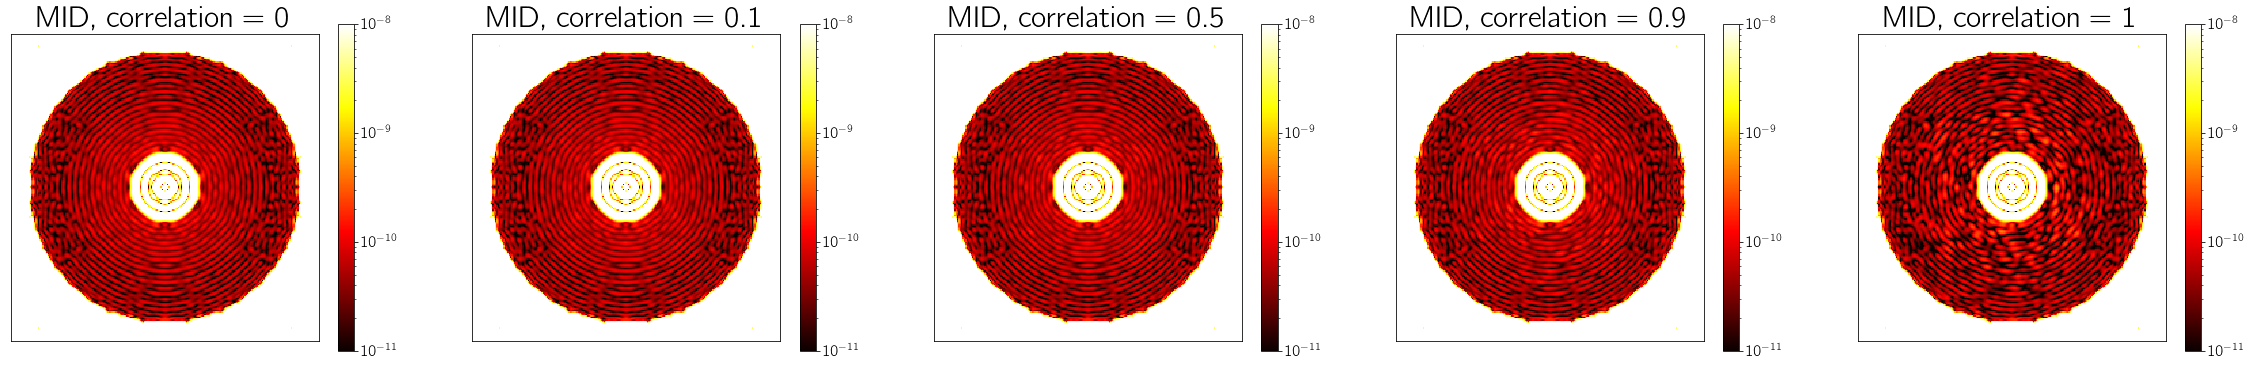

In [867]:
n_trial = 100
# Nwavescale = 3
# WaveScaleMinus = 0
# WaveScalePlus = 1
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
wavescale = 1.
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
MID_modes = np.random.multivariate_normal(np.zeros(n_MID),wavescale*QMID)
corr_vec = [0,0.1,0.5,0.9,1]
n_corr = len(corr_vec)
image_stack = np.zeros([n_corr,n_trial, Efield_ref.shape[0]])
for qq in range(0,n_corr):
    corr = corr_vec[qq]
    for pp in range(0,n_trial):
        MID_modes = corr*MID_modes + np.sqrt(1-corr**2)*np.random.multivariate_normal(np.zeros(n_MID),wavescale*QMID)
        luvoir.sm.actuators = MID_modes
        tmp0 = np.abs(np.dot(MID_modes,G_coron_MIDAll) + Efield_ref)**2
        image_stack[qq,pp] = tmp0/norm
mean_img_s = np.reshape(np.mean(image_stack,1),[5,227,227])
fig, axs = plt.subplots(1, n_corr,figsize=(40, 10))
# plt.figure(figsize=(10, 10))
for qq in range(0,n_corr):
    pcm =  axs[qq].imshow(mean_img_s[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-8),cmap = 'hot')
    fig.colorbar(pcm,ax = axs[qq],shrink=0.6)
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
    axs[qq].set_title('MID, correlation = ' + np.str(corr_vec[qq]), size=30)
decorr_im = np.abs(np.mean(image_stack[0],0) - np.abs(Efield_ref)**2/norm)
decorr_im_shot_1phot = np.sqrt(norm*decorr_im)/norm
print(np.mean(decorr_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))
# file_name = 'MID_modes_DH_corr' + '.pdf'
# fig.savefig(file_name)

In [868]:
mean_img_s_line = np.reshape(mean_img_s,[5,227*227])
raw_cont = np.mean(mean_img_s_line[0][np.where(dh_mask != 0)])
test_im = np.abs(mean_img_s_line[0] - np.abs(Efield_ref)**2/norm)
#test_im = np.abs(mean_img_s_line[4])
test_im_shot_1phot = np.sqrt(norm*test_im)/norm
print(np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))
MID_halo_contrast_photons = np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long)
test_im = np.abs(mean_img_s_line[4] - np.abs(Efield_ref)**2/norm)
print(np.mean(test_im[np.where(dh_mask != 0)]))
MID_speckles_contrast = np.mean(test_im[np.where(dh_mask != 0)])

7.618995583594981e-12
2.4403733801706885e-11


In [869]:
Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 12
WaveScaleMinus = -2
WaveScalePlus = 2
Nflux = 3
fluxPlus = 10
fluxMinus = 0
NiterBatch = 20
NiterRecursive = 100
timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

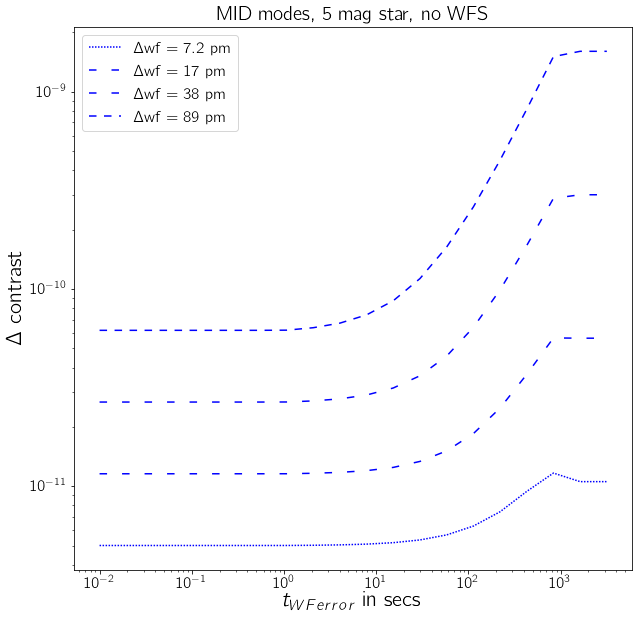

In [871]:
def average_MID(tscale,wavescale,StarMag):
    Starfactor = 10**(-StarMag/2.5)
    if tscale < 1:
        tmp_alpha = 0
    elif tscale > t_long/4:
        tmp_alpha = 1
    else:
        tmp_alpha = (tscale - 1)/t_long*4
    tmp_photons = wavescale*MID_halo_contrast_photons/np.sqrt(Starfactor)
    tmp_speckles = wavescale**2*MID_speckles_contrast 
    tmp = tmp_alpha*tmp_speckles + np.sqrt(1-tmp_alpha**2)*tmp_photons
    return tmp
res = np.zeros([Ntimes,Nwavescale,Nflux,1])
pp = 0
for tscale in np.logspace(TimeMinus,TimePlus,Ntimes):
    qq = 0
    for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
        rr = 0
        for StarMag in np.linspace(fluxMinus,fluxPlus,Nflux):
            res[pp,qq,rr] = average_MID(tscale,wavescale,StarMag)
            rr = rr + 1
        qq = qq + 1
    pp = pp + 1
fig = plt.figure(figsize=(10, 10))
for wavefront_index  in np.arange(5,9,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res[:,wavefront_index,1],linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFerror}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 5 mag star, no WFS',fontsize = 20)
file_name = 'MID_modes_SandF_Photon_contrast' + '.pdf'
fig.savefig(file_name)

7.97148607524674e-12


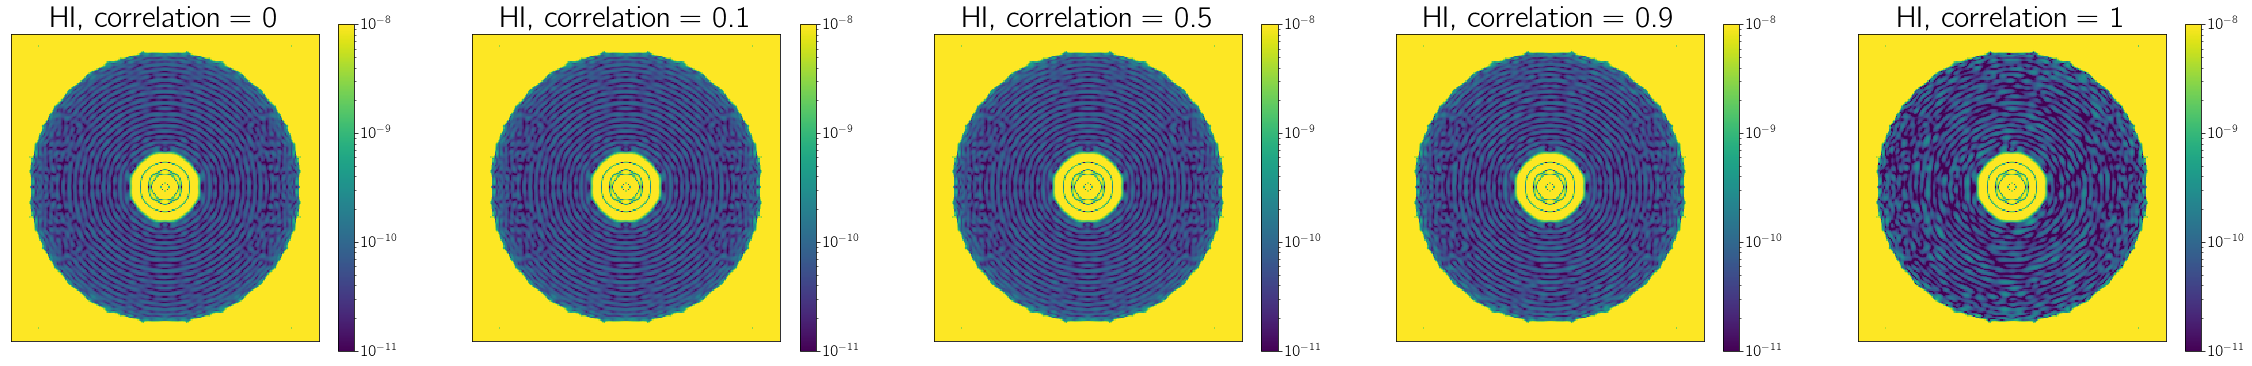

In [872]:
n_trial = 100
# Nwavescale = 3
# WaveScaleMinus = 0
# WaveScalePlus = 1
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
dh_intensity_stack = np.zeros([Nwavescale,n_trial])
dh_var_stack = np.zeros([Nwavescale,n_trial])
wavescale = 1.
image_stack = np.zeros([n_trial, Efield_ref.shape[0]])
HI_modes = np.random.multivariate_normal(np.zeros(n_HI),wavescale*QHI)
corr_vec = [0,0.1,0.5,0.9,1]
n_corr = len(corr_vec)
image_stack = np.zeros([n_corr,n_trial, Efield_ref.shape[0]])
for qq in range(0,n_corr):
    corr = corr_vec[qq]
    for pp in range(0,n_trial):
        HI_modes = corr*HI_modes + np.sqrt(1-corr**2)*np.random.multivariate_normal(np.zeros(n_HI),wavescale*QHI)
        tmp0 = np.abs(np.dot(HI_modes,G_coron_HIAll) + Efield_ref)**2
        image_stack[qq,pp] = tmp0/norm
mean_img_s = np.reshape(np.mean(image_stack,1),[5,227,227])
fig, axs = plt.subplots(1, n_corr,figsize=(40, 10))
# plt.figure(figsize=(10, 10))
for qq in range(0,n_corr):
    pcm =  axs[qq].imshow(mean_img_s[qq],norm=LogNorm(),vmin=10**(-11), vmax=10**(-8))
    fig.colorbar(pcm,ax = axs[qq],shrink=0.6)
    axs[qq].axes.get_xaxis().set_visible(False)
    axs[qq].axes.get_yaxis().set_visible(False)
    axs[qq].set_title('HI, correlation = ' + np.str(corr_vec[qq]), size=30)
decorr_im = np.abs(np.mean(image_stack[0],0) - np.abs(Efield_ref)**2/norm)
decorr_im_shot_1phot = np.sqrt(norm*decorr_im)/norm
print(np.mean(decorr_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))

In [873]:
mean_img_s_line = np.reshape(mean_img_s,[5,227*227])
raw_cont = np.mean(mean_img_s_line[0][np.where(dh_mask != 0)])
test_im = np.abs(mean_img_s_line[0] - np.abs(Efield_ref)**2/norm)
#test_im = np.abs(mean_img_s_line[4])
test_im_shot_1phot = np.sqrt(norm*test_im)/norm
print(np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long/100))
HI_halo_contrast_photons = np.mean(test_im_shot_1phot[np.where(dh_mask != 0)])/np.sqrt(Nph*t_long)
test_im = np.abs(mean_img_s_line[4] - np.abs(Efield_ref)**2/norm)
print(np.mean(test_im[np.where(dh_mask != 0)]))
HI_speckles_contrast = np.mean(test_im[np.where(dh_mask != 0)])

7.97148607524674e-12
2.8438908740490863e-11


In [874]:
Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 12
WaveScaleMinus = -2
WaveScalePlus = 2
Nflux = 3
fluxPlus = 10
fluxMinus = 0
NiterBatch = 20
NiterRecursive = 100
timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

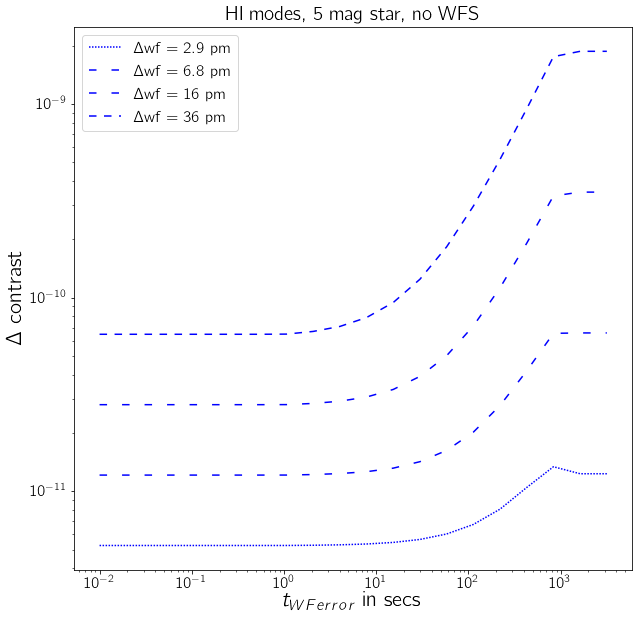

In [875]:
def average_HI(tscale,wavescale,StarMag):
    Starfactor = 10**(-StarMag/2.5)
    if tscale < 1:
        tmp_alpha = 0
    elif tscale > t_long/4:
        tmp_alpha = 1
    else:
        tmp_alpha = (tscale - 1)/t_long*4
    tmp_photons = wavescale*HI_halo_contrast_photons/np.sqrt(Starfactor)
    tmp_speckles = wavescale**2*HI_speckles_contrast 
    tmp = tmp_alpha*tmp_speckles + np.sqrt(1-tmp_alpha**2)*tmp_photons
    return tmp
res = np.zeros([Ntimes,Nwavescale,Nflux,1])
pp = 0
for tscale in np.logspace(TimeMinus,TimePlus,Ntimes):
    qq = 0
    for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
        rr = 0
        for StarMag in np.linspace(fluxMinus,fluxPlus,Nflux):
            res[pp,qq,rr] = average_HI(tscale,wavescale,StarMag)
            rr = rr + 1
        qq = qq + 1
    pp = pp + 1
fig = plt.figure(figsize=(10, 10))
for wavefront_index  in np.arange(5,9,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wHI_11*wavefront_factor*10**12,2)+' pm'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res[:,wavefront_index,1],linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFerror}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('HI modes, 5 mag star, no WFS',fontsize = 20)
file_name = 'HI_modes_SandF_Photon_contrast' + '.pdf'
fig.savefig(file_name)

# Unpacking requiremnts with Leonid's method

In [1066]:
res_LO_batch_DH_line = np.loadtxt("LObatchDH.csv", delimiter=",")
res_LO_batch_LOWFS_line = np.loadtxt("LObatchLOWFS.csv", delimiter=",")
res_LO_recursiveDH_line = np.loadtxt("LOrecursiveDH.csv", delimiter=",")
res_LO_recursive_LOWFS = np.loadtxt("LOrecursiveDH.csv", delimiter=",")
res_MID_batch_OBWFS_line = np.loadtxt("MIDbatchOBWFS.csv", delimiter=",")
res_MID_recursive_OBWFS_line = np.loadtxt("MIDrecursiveOBWFS.csv", delimiter=",")
res_MID_batch_DH_line = np.loadtxt("MIDbatchDH3.csv", delimiter=",")
res_HI_batch_DH_line = np.loadtxt("HIbatchDH.csv", delimiter=",")

## LO modes

In [911]:
Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 20
WaveScaleMinus = -2
WaveScalePlus = 2
Nflux = 10
fluxPlus = 9
fluxMinus = 0
Niter = 100
timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

In [912]:
res_LO_batch_DH = np.reshape(res_LO_batch_DH_line,[Ntimes,Nwavescale,Nflux,1])
res_LO_batch_LOWFS = np.reshape(res_LO_batch_LOWFS_line,[Ntimes,Nwavescale,Nflux,1])
res_LO_recursiveDH = np.reshape(res_LO_recursiveDH_line,[Ntimes,Nwavescale,Nflux,1])
res_LO_recursive_LOWFS = np.reshape(res_LO_recursive_LOWFS_line,[Ntimes,Nwavescale,Nflux,1])

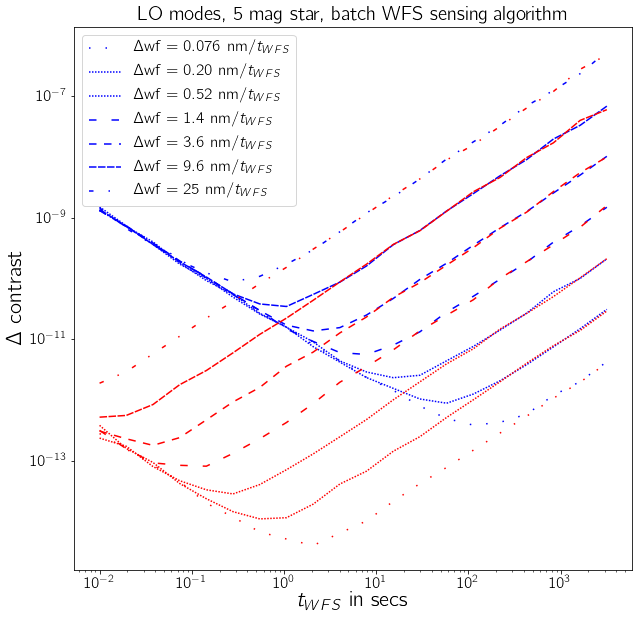

In [914]:
fig = plt.figure(figsize=(10, 10))
for wavefront_index  in np.arange(0,14,2):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wLO_11*wavefront_factor*10**9,2)+' nm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_LO_batch_DH[:,wavefront_index,6] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,14,2):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wLO_11*wavefront_factor*10**9,2)+' nm/$t_{WFS}$, using LOWFS'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_LO_batch_LOWFS[:,wavefront_index,6] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='red')
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('LO modes, 5 mag star, batch WFS sensing algorithm',fontsize = 20)
file_name = 'LO_modes_WFSC_batch_contrast' + '.pdf'
fig.savefig(file_name)

## MID and HI Modes

In [1067]:
Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 12
WaveScaleMinus = -2
WaveScalePlus = 2
Nflux = 3
fluxPlus = 10
fluxMinus = 0
NiterBatch = 20
NiterRecursive = 100
timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

In [1068]:
res_MID_batch_OBWFS = np.reshape(res_MID_batch_OBWFS_line,[Ntimes,Nwavescale,Nflux,1])
res_MID_recursive_OBWFS = np.reshape(res_MID_recursive_OBWFS_line,[Ntimes,Nwavescale,Nflux,1])
res_MID_batch_DH = np.reshape(res_MID_batch_DH_line,[Ntimes,Nwavescale,Nflux,1])
res_HI_batch_DH = np.reshape(res_HI_batch_DH_line,[Ntimes,Nwavescale,Nflux,1])

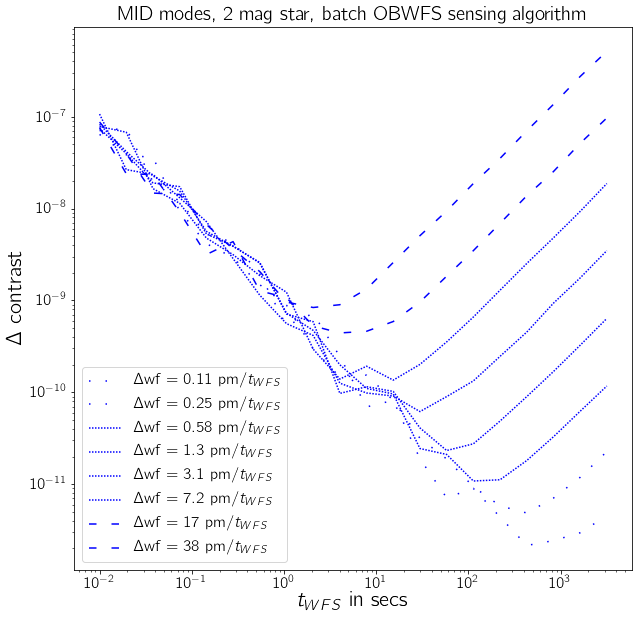

In [1069]:
# fig, axs = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1,figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 2 mag star, batch OBWFS sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_batch_contrast_mag0' + '.pdf'
fig.savefig(file_name)

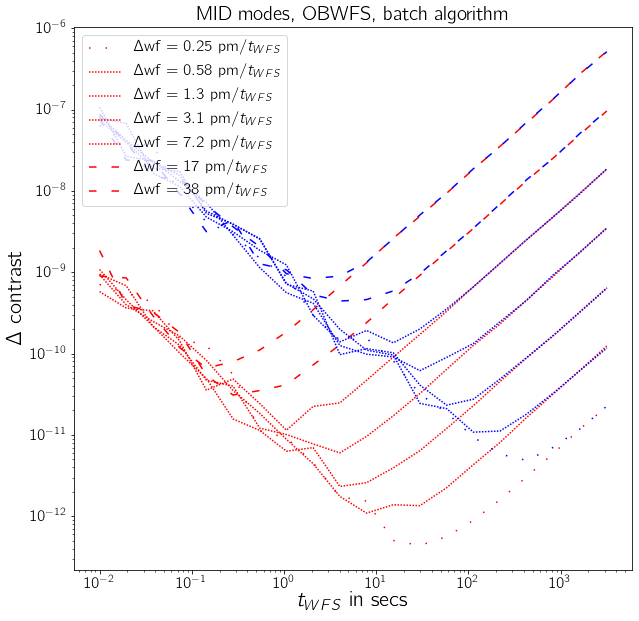

In [1070]:
# fig, axs = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1,figsize=(10, 10))
for wavefront_index  in np.arange(1,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,0] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='red',label = labeltext)
for wavefront_index  in np.arange(1,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue')
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend(loc = 'upper left')
plt.title('MID modes, OBWFS, batch algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_batch_contrast_mag_POIL' + '.pdf'
fig.savefig(file_name)

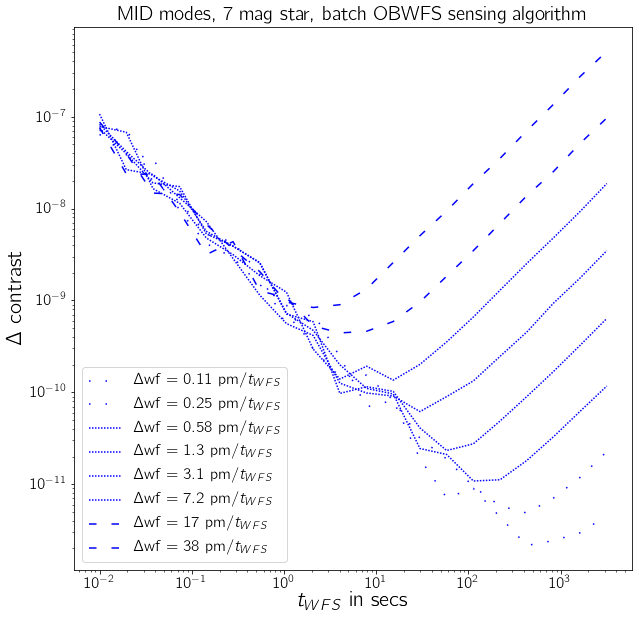

In [1071]:
# fig, axs = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1,figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 7 mag star, batch OBWFS sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_batch_contrast_mag5' + '.pdf'
fig.savefig(file_name)

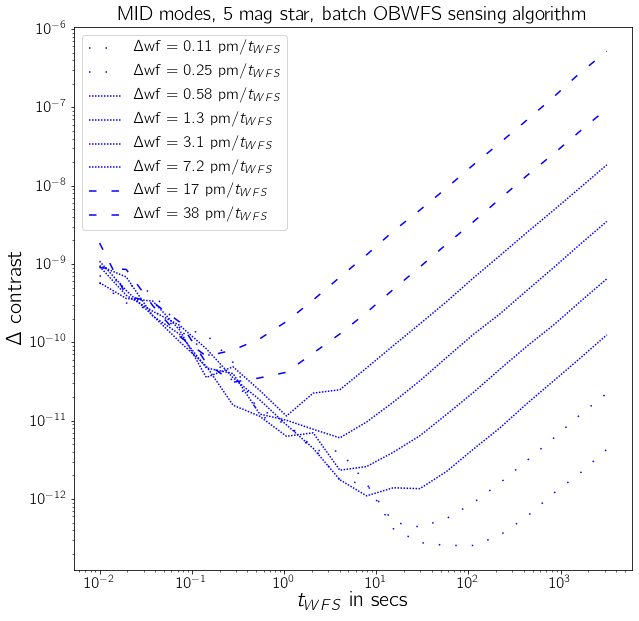

In [1011]:
# fig, axs = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1,figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,0] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 5 mag star, batch OBWFS sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_batch_contrast_mag0' + '.pdf'
fig.savefig(file_name)

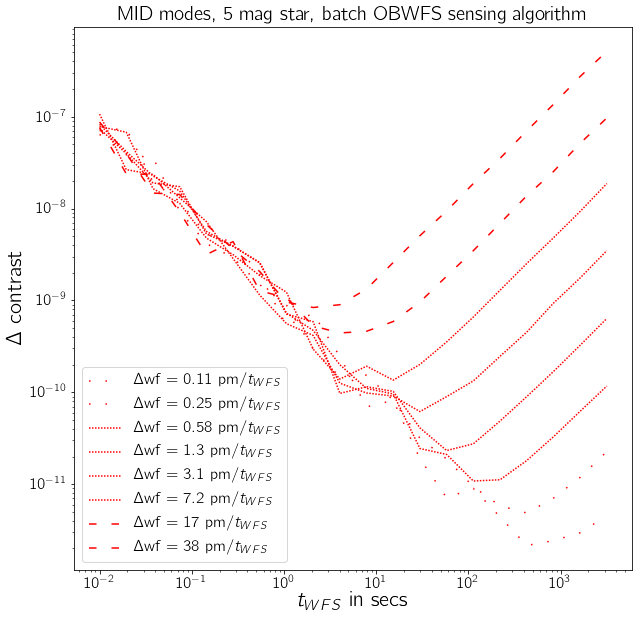

In [1039]:
plt.figure(figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='red',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 5 mag star, batch OBWFS sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_batch_contrast_mag5' + '.pdf'
fig.savefig(file_name)

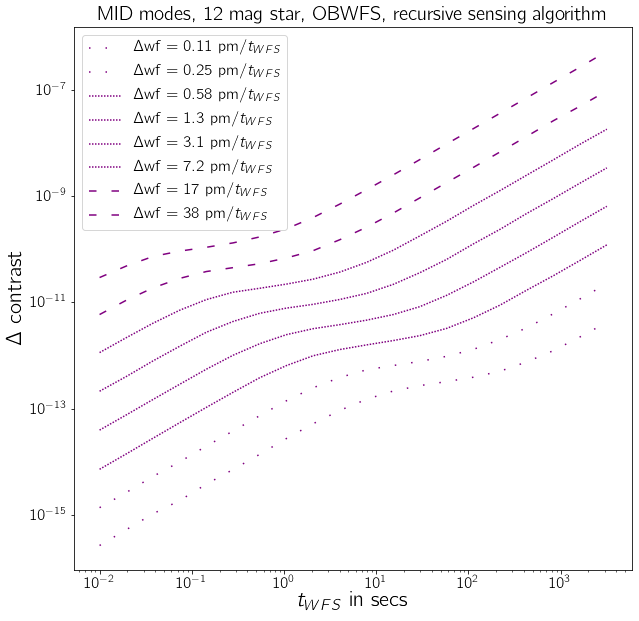

In [1072]:
fig = plt.figure(figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_recursive_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='purple',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 12 mag star, OBWFS, recursive sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_recursive_contrast_mag5' + '.pdf'
fig.savefig(file_name)

In [1031]:
res_MID_batch_OBWFS.shape

(20, 12, 3, 1)

In [1073]:
res_MID_recursive_OBWFS_fudged = np.zeros(res_MID_recursive_OBWFS.shape)

In [1078]:
import copy

In [1082]:
res_MID_recursive_OBWFS_fudged = np.zeros(res_MID_recursive_OBWFS.shape)
for pp in range(0,12):
    for qq in range(0,3):
        tmp = res_MID_recursive_OBWFS[:,pp,qq]
        min_bound = np.min(res_MID_batch_OBWFS[:,pp,qq])/2
        tmp0 = copy.copy(tmp)
        print(min_bound)
        tmp0[np.where(tmp0<min_bound)] = min_bound
        res_MID_recursive_OBWFS_fudged[:,pp,qq] = tmp0

1.975137042642331e-11
2.0701162003667453e-11
4.035583287110732e-11
1.9843236908681258e-11
2.2054917976221375e-11
4.185145056698107e-11
2.0171816129036083e-11
2.5043022181351402e-11
9.224450863782656e-11
2.0787949429143207e-11
3.1254300531323055e-11
1.1812005994074674e-10
2.2636079033490673e-11
5.048212963876968e-11
3.015218172547004e-10
2.535073302003731e-11
8.747859564498988e-11
5.937830791039188e-10
3.5095547264479984e-11
2.408912388806423e-10
1.3324105156613361e-09
5.290920521835106e-11
4.3838550906668935e-10
3.3682135046165e-09
1.0841515566092364e-10
7.43204997392351e-10
7.902765081697353e-09
1.877631395351271e-10
2.303909311875136e-09
1.8591555080300053e-08
5.289640896660815e-10
3.851498970856249e-09
4.3501557071492204e-08
1.1293348374569568e-09
1.0889586363054076e-08
6.676117951568603e-08


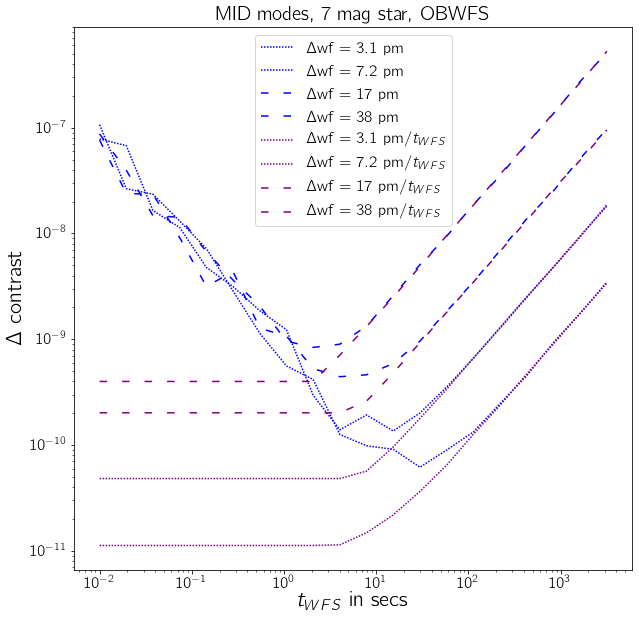

In [1088]:
fig = plt.figure(figsize=(10, 10))
for wavefront_index  in np.arange(4,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_batch_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(4,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_recursive_OBWFS_fudged[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='purple',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 7 mag star, OBWFS',fontsize = 20)
file_name = 'MID_modes_WFSC_recursive_batch_comp' + '.pdf'
fig.savefig(file_name)

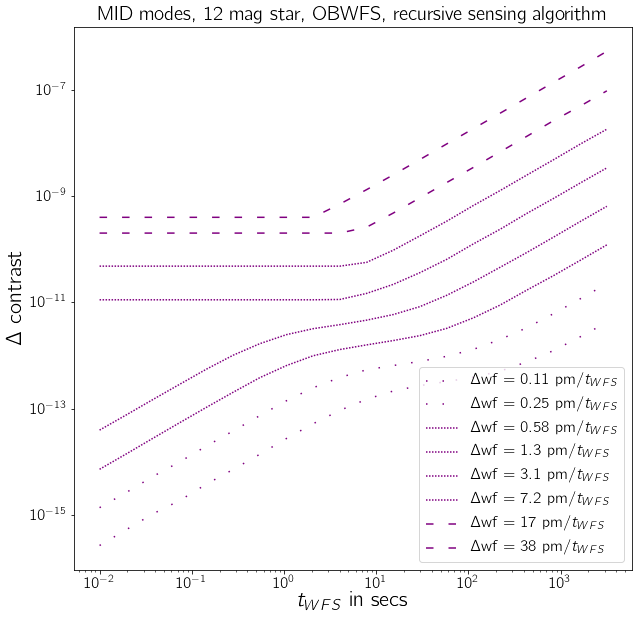

In [1041]:
fig = plt.figure(figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_recursive_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='purple',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 12 mag star, OBWFS, recursive sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_recursive_contrast_mag5' + '.pdf'
fig.savefig(file_name)

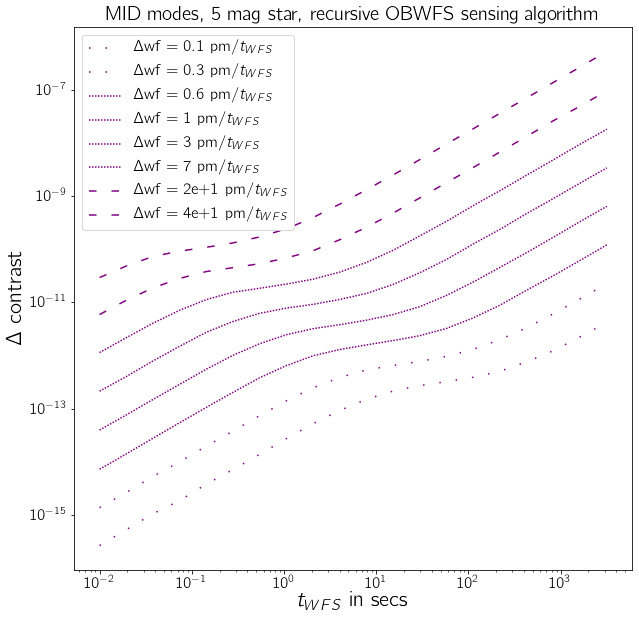

In [1016]:
fig = plt.figure(figsize=(10, 10))
# for wavefront_index  in np.arange(0,12,2):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
for wavefront_index  in np.arange(0,8,1):
    wavefront_factor = WaveVec[wavefront_index]
    labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,1)+' pm/$t_{WFS}$'
    index_line = np.int(wavefront_index/2)
    plt.plot(timeVec,res_MID_recursive_OBWFS[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='purple',label = labeltext)
plt.semilogy()
plt.semilogx()
plt.xlabel('$t_{WFS}$ in secs')
plt.ylabel('$\Delta$ contrast')
plt.legend()
plt.title('MID modes, 5 mag star, recursive OBWFS sensing algorithm',fontsize = 20)
file_name = 'MID_modes_WFSC_recursive_contrast_mag5' + '.pdf'
fig.savefig(file_name)

In [690]:
# plt.figure(figsize=(10, 10))
# # for wavefront_index  in np.arange(0,12,2):
# #     wavefront_factor = WaveVec[wavefront_index]
# #     labeltext = '$\Delta$wf = ' + to_precision(wMID_11*wavefront_factor*10**12,2)+' pm'
# #     index_line = np.int(wavefront_index/2)
# #     plt.plot(timeVec,res_MID_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='blue',label = labeltext)
# for wavefront_index  in np.arange(0,8,1):
#     wavefront_factor = WaveVec[wavefront_index]
#     labeltext = '$\Delta$wf = ' + to_precision(wHI_11*wavefront_factor*10**12,2)+' pm, using LOWFS'
#     index_line = np.int(wavefront_index/2)
#     plt.plot(timeVec,res_HI_batch_DH[:,wavefront_index,1] - contrast_floor,linestyle = linestyle_tuple[index_line][1],linewidth=1.5, color='red',label = labeltext)
# plt.semilogy()
# plt.semilogx()
# plt.xlabel('$t_{WFS}$ in secs')
# plt.ylabel('$\Delta$ contrast')
# plt.legend()
# plt.title('MID modes, 5 mag star, batch WFS sensing algorithm',fontsize = 20)

# Checking reqs by hand

In [691]:
# From Neill Z calculation
fudge_core = 2 # not exactly right hence the fudge, debug with full aperture
Nph = fudge_core*2.052e09*luvoir.wvln/eunit*0.1

In [692]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate=False)
norm = np.max(ref)
#the normalization is not perfect yet

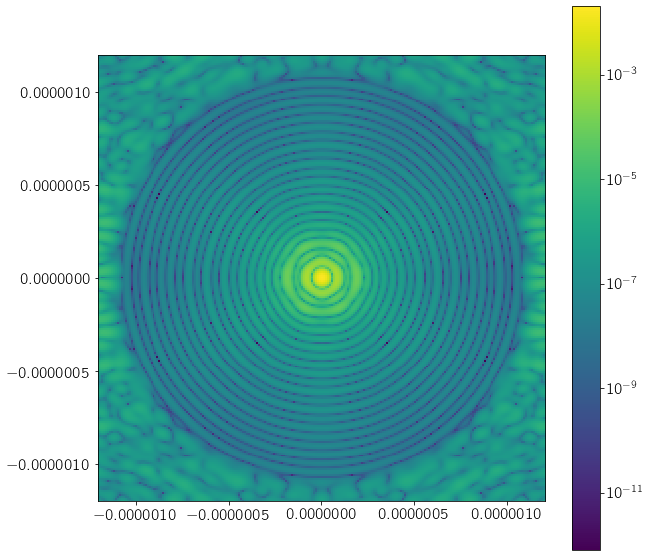

In [693]:
plt.figure(figsize=(10, 10))
hc.imshow_field(ref, norm=LogNorm())
plt.colorbar()

In [694]:
core = hc.circular_aperture(2 * 0.7 * luvoir.lam_over_d)(luvoir.focal_det)
core_mask = (core).astype('bool')

In [695]:
np.sum(np.abs(ref))

Field(0.58200529)

In [696]:
np.sum(np.abs(core_mask*ref)) #so that is a factor of two

Field(0.29402903)

In [697]:
fudge_fluxes = z_pup_downsample

In [698]:
LO_modes = np.zeros(n_LO)
MID_modes = np.zeros(n_MID)
HI_modes = np.zeros(n_HI)
DM_modes = np.zeros(n_DM)
luvoir.zm.actuators = LO_modes
luvoir.sm.actuators = MID_modes
luvoir.fm.actuators = HI_modes
luvoir.dm.actuators = DM_modes

nonaberrated_coro_psf, refshit,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = inter_ref['at_science_focus'].electric_field
zernike_ref = luvoir.prop_LOWFS()
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real, z_pup_downsample, grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_LOWFS = (zernike_ref_sub_real + 1j*zernike_ref_sub_imag)*z_pup_downsample

zernike_ref = luvoir.prop_OBWFS()
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real, z_pup_downsample, grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_OBWFS = (zernike_ref_sub_real + 1j*zernike_ref_sub_imag)*z_pup_downsample

In [848]:
zernike_ref_sub_real = hc.field.subsample_field(zernike_ref.real, z_pup_downsample, grid_zernike, statistic='mean')
zernike_ref_sub_imag = hc.field.subsample_field(zernike_ref.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_LOWFS = (zernike_ref_sub_real + 1j*zernike_ref_sub_imag)*z_pup_downsample

In [851]:
np.sum(np.abs(Efield_ref_LOWFS)**2)

Field(0.60850119)

In [850]:
np.sum(np.abs(zernike_ref.amplitude)**2)

Field(0.62605756)

In [699]:
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref_LOWFS.imag)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref_LOWFS.real)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref.real)
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# hc.imshow_field(Efield_ref.imag)
# plt.colorbar()

In [700]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_LO[:,0,0],[227,227]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_LO[:,1,0],[227,227]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_LOWFS[:,0,0],[100,100]))
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_LOWFS[:,1,0],[100,100]))
# plt.colorbar()

In [701]:
nyquist_sampling = 2.
grid_det_subsample = hc.make_focal_grid(
            nyquist_sampling,
            np.floor(luvoir.imlamD),
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
### Dark hole mask
dh_outer_nyquist = hc.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_inner_nyquist = hc.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_mask_nyquist = (dh_outer_nyquist - dh_inner_nyquist).astype('bool')
tmp = hc.interpolation.make_linear_interpolator_separated(ref,grid=grid_test)
ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
norm_nyquist = np.max(ref_nyquist)
tmp = hc.interpolation.make_linear_interpolator_separated(unaberrated_coro_psf, grid=grid_test)
test = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)

In [705]:
# n_nyquist = np.int(np.sqrt(grid_det_subsample.x.shape[0]))
# tic = time()
# tmp = hc.interpolation.make_linear_interpolator_separated(G_LO_real[0], grid=grid_test)
# test = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
# toc = time()
# print(toc - tic)

0.02202916145324707


In [706]:
dh_size = len(np.where(dh_mask != 0)[0])
dh_size_nyquist = len(np.where(dh_mask_nyquist != 0)[0])
dh_index = np.where(dh_mask != 0)[0]
dh_index_nyquist = np.where(dh_mask_nyquist != 0)[0]

In [707]:
n_img = np.int(np.sqrt(Efield_ref.shape))
E0_LOWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_LOWFS[:,0,0] = Efield_ref_LOWFS.real
E0_LOWFS[:,0,1] = Efield_ref_LOWFS.imag
E0_OBWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_OBWFS[:,0,0] = Efield_ref_OBWFS.real
E0_OBWFS[:,0,1] = Efield_ref_OBWFS.imag
E0_coron = np.zeros([n_img*n_img,1,2])
E0_coron[:,0,0] = Efield_ref.real
E0_coron[:,0,1] = Efield_ref.imag
E0_coron_nyquist = np.zeros([n_nyquist*n_nyquist,1,2])
tmp0 = hc.interpolation.make_linear_interpolator_separated(Efield_ref, grid=grid_test)
Efield_ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
E0_coron_nyquist[:,0,0] = Efield_ref_nyquist.real
E0_coron_nyquist[:,0,1] = Efield_ref_nyquist.imag
E0_coron_DH = np.zeros([dh_size,1,2])
E0_coron_DH[:,0,0] = Efield_ref.real[dh_index]
E0_coron_DH[:,0,1] = Efield_ref.imag[dh_index]
E0_coron_DH_nyquist = np.zeros([dh_size_nyquist,1,2])
E0_coron_DH_nyquist[:,0,0] = Efield_ref_nyquist[dh_index_nyquist]
E0_coron_DH_nyquist[:,0,1] = Efield_ref_nyquist[dh_index_nyquist]

In [708]:
G_coron_LO_nyquist = np.zeros([n_nyquist*n_nyquist,2,n_LO-1])
for pp in range(1,n_LO):
    tmp0 = G_LO_real[pp] + 1j*G_LO_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_LO_nyquist[:,0,pp-1] = tmp2.real - Efield_ref_nyquist.real
    G_coron_LO_nyquist[:,1,pp-1] = tmp2.real - Efield_ref_nyquist.imag
G_coron_MID_nyquist= np.zeros([n_nyquist*n_nyquist,2,n_MID])
for pp in range(0,n_MID):
    tmp0 = G_MID_real[pp] + 1j*G_MID_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_MID_nyquist[:,0,pp] = tmp2.real - Efield_ref_nyquist.real
    G_coron_MID_nyquist[:,1,pp] = tmp2.real - Efield_ref_nyquist.imag
G_coron_HI_nyquist= np.zeros([n_nyquist*n_nyquist,2,n_HI])
for pp in range(0,n_HI):
    tmp0 = G_HI_real[pp] + 1j*G_HI_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_HI_nyquist[:,0,pp] = tmp2.real - Efield_ref_nyquist.real
    G_coron_HI_nyquist[:,1,pp] = tmp2.real - Efield_ref_nyquist.imag

In [709]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO_DH = np.zeros([dh_size,2,n_LO-1])
for pp in range(1,n_LO):
    G_coron_LO_DH[:,0,pp-1] = G_LO_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_LO_DH[:,1,pp-1] = G_LO_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_MID_DH= np.zeros([dh_size,2,n_MID])
for pp in range(0,n_MID):
    G_coron_MID_DH[:,0,pp] = G_MID_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_MID_DH[:,1,pp] = G_MID_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_HI_DH= np.zeros([dh_size,2,n_HI])
for pp in range(0,n_HI):
    G_coron_HI_DH[:,0,pp] = G_HI_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_HI_DH[:,1,pp] = G_HI_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [710]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO_DH_nyquist = np.zeros([dh_size_nyquist,2,n_LO-1])
for pp in range(1,n_LO):
    tmp0 = G_LO_real[pp] + 1j*G_LO_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_LO_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
    G_coron_LO_DH_nyquist[:,1,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist]
#     G_coron_LO_DH[:,0,pp-1] = G_LO_real[pp,dh_index] - Efield_ref.real[dh_index]
#     G_coron_LO_DH[:,1,pp-1] = G_LO_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_MID_DH_nyquist= np.zeros([dh_size_nyquist,2,n_MID])
for pp in range(0,n_MID):
    tmp0 = G_MID_real[pp] + 1j*G_MID_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_MID_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
    G_coron_MID_DH_nyquist[:,1,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist]
G_coron_HI_DH_nyquist= np.zeros([dh_size_nyquist,2,n_HI])
for pp in range(0,n_HI):
    tmp0 = G_HI_real[pp] + 1j*G_HI_imag[pp]
    tmp1 = hc.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp(grid_det_subsample)
    G_coron_HI_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
    G_coron_HI_DH_nyquist[:,1,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist] 

In [711]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO_DH = np.zeros([dh_size,2,n_LO-1])
for pp in range(1,n_LO):
    G_coron_LO_DH[:,0,pp-1] = G_LO_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_LO_DH[:,1,pp-1] = G_LO_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_MID_DH= np.zeros([dh_size,2,n_MID])
for pp in range(0,n_MID):
    G_coron_MID_DH[:,0,pp] = G_MID_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_MID_DH[:,1,pp] = G_MID_imag[pp,dh_index] - Efield_ref.imag[dh_index]
G_coron_HI_DH= np.zeros([dh_size,2,n_HI])
for pp in range(0,n_HI):
    G_coron_HI_DH[:,0,pp] = G_HI_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_HI_DH[:,1,pp] = G_HI_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [712]:
n_img = np.int(np.sqrt(Efield_ref.shape))
G_coron_LO = np.zeros([n_img*n_img,2,n_LO-1])
for pp in range(1,n_LO):
    G_coron_LO[:,0,pp-1] = G_LO_real[pp] - Efield_ref.real
    G_coron_LO[:,1,pp-1] = G_LO_imag[pp] - Efield_ref.imag
G_coron_MID= np.zeros([n_img*n_img,2,n_MID])
for pp in range(0,n_MID):
    G_coron_MID[:,0,pp] = G_MID_real[pp] - Efield_ref.real
    G_coron_MID[:,1,pp] = G_MID_imag[pp] - Efield_ref.imag
G_coron_HI= np.zeros([n_img*n_img,2,n_HI])
for pp in range(0,n_HI):
    G_coron_HI[:,0,pp] = G_HI_real[pp] - Efield_ref.real
    G_coron_HI[:,1,pp] = G_HI_imag[pp] - Efield_ref.imag

In [713]:
G_LOWFS = np.zeros([N_pup_z*N_pup_z,2,n_LO-1])
for pp in range(1,n_LO):
    G_LOWFS[:,0,pp-1] = G_LOWFS_real[pp]*z_pup_downsample - Efield_ref_LOWFS.real
    G_LOWFS[:,1,pp-1] = G_LOWFS_imag[pp]*z_pup_downsample - Efield_ref_LOWFS.imag
G_OBWFS= np.zeros([N_pup_z*N_pup_z,2,n_MID])
for pp in range(0,n_MID):
    G_OBWFS[:,0,pp] = G_OBWFS_real[pp]*z_pup_downsample - Efield_ref_OBWFS.real
    G_OBWFS[:,1,pp] = G_OBWFS_imag[pp]*z_pup_downsample - Efield_ref_OBWFS.imag

In [714]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_LOWFS[:,1,1],[100,100]))
# plt.colorbar()

In [715]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_HI[:,1,400]**2+G_coron_HI[:,0,2]**2,[227,227]),norm=LogNorm())
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_MID[:,1,400]**2+G_coron_MID[:,0,2]**2,[227,227]),norm=LogNorm())
# plt.colorbar()
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_coron_LO[:,1,8]**2+G_coron_LO[:,0,2]**2,[227,227]),norm=LogNorm())
# plt.colorbar()

In [716]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.reshape(G_OBWFS[:,1,2],[100,100]))
# plt.colorbar()

In [717]:
# N = 100*100
# N_img = n_img*n_img
# # Q = np.eye(r)
# fudge_std = 0.03
# Q =  np.diag((mu_map*fudge_std)**2)
# c = 1
# t_exp = 60
# flux = Nph/100
# # D = Nph/1e9
# D = 0
# P = Q*0.0

In [718]:
def req_closedloop_calc_recursive(Gcoro,Gsensor,E0coro,E0sensor,Dcoro,Dsensor,t_exp,flux,Q,Niter,dh_mask,norm):
    
    P = np.zeros(Q.shape)#WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    #Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter,r])
    averaged_hist = np.zeros(Niter) 
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P+Q*t_exp).reshape((1,1,r)) #random modes
        G_eps = np.sum(Gsensor*eps, axis=2).reshape((N,1,2*c)) + E0sensor #electric field
        G_eps_squared = np.sum(G_eps*G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G/np.sqrt(G_eps_squared + Dsensor/flux/t_exp) #trick to save RAM
        cal_I = 4*flux*t_exp*np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled) #information matrix
        P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
#         P = np.linalg.inv(cal_I)

    #Coronagraph
        G_eps_coron = np.sum(Gcoro*eps, axis=2).reshape((N_img,1,2*c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron*G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared*flux*t_exp + Dcoro

    # Wavefront sensor
        intensity_WFS = G_eps_squared*flux*t_exp + Dsensor

    # Archive
        test_DH0 = intensity[:,0,0]*dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH/flux/t_exp/norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS)/flux
        cal_I_hist[pp] = np.mean(cal_I)/flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
#         print("est. contrast", np.mean(contrasts))

        
        outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                             'cal_I_hist': cal_I_hist,
                             'eps_hist': eps_hist,
                             'averaged_hist': averaged_hist,
                             'contrasts': contrasts}
    return outputs

In [719]:
def req_closedloop_calc_batch(Gcoro,Gsensor,E0coro,E0sensor,Dcoro,Dsensor,t_exp,flux,Q,Niter,dh_mask,norm):
    
    P = np.zeros(Q.shape)#WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    #Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter,r])
    averaged_hist = np.zeros(Niter) 
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P+Q*t_exp).reshape((1,1,r)) #random modes
        G_eps = np.sum(Gsensor*eps, axis=2).reshape((N,1,2*c)) + E0sensor #electric field
        G_eps_squared = np.sum(G_eps*G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G/np.sqrt(G_eps_squared + Dsensor/flux/t_exp) #trick to save RAM
        cal_I = 4*flux*t_exp*np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled) #information matrix
#         P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
        P = np.linalg.pinv(cal_I)

    #Coronagraph
        G_eps_coron = np.sum(Gcoro*eps, axis=2).reshape((N_img,1,2*c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron*G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared*flux*t_exp + Dcoro

    # Wavefront sensor
        intensity_WFS = G_eps_squared*flux*t_exp + Dsensor

    # Archive
        test_DH0 = intensity[:,0,0]*dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH/flux/t_exp/norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS)/flux
        cal_I_hist[pp] = np.mean(cal_I)/flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
#         print("est. contrast", np.mean(contrasts))
#         print("est. contrast", np.mean(contrasts))
        
    outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                         'cal_I_hist': cal_I_hist,
                         'eps_hist': eps_hist,
                         'averaged_hist': averaged_hist,
                         'contrasts': contrasts}
        
    return outputs

In [720]:
QLO = np.diag(np.asarray(mu_mapLO**2))
QMID = np.diag(np.asarray(mu_mapMID**2))
QHI = np.diag(np.asarray(mu_mapHI**2))
flux = Nph

# LO Modes

LO batch, LOWFS

In [955]:
StarMag = 5
Starfactor = 10**(-StarMag/2.5)
tscale = 0.1
wavescale = 3

In [956]:
tmp0 = req_closedloop_calc_batch(G_coron_LO,G_LOWFS,E0_coron,E0_LOWFS,0,0,tscale,flux*Starfactor,wavescale**2*QLO,Niter,dh_mask,norm)
#tmp0 = req_closedloop_calc_batch(G_coron_LO,G_LOWFS,E0_coron,E0_LOWFS,0,0,tscale,flux*Starfactor,wavescale**2*QLO,Niter)

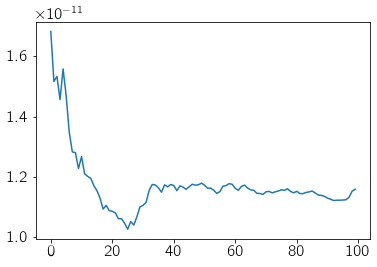

In [957]:
tmp1 = tmp0['averaged_hist']
plt.plot(tmp1-contrast_floor)

In [958]:
ZernikeList = []
for pp in range(0,n_LO-1):
    ZernikeList.append('Global Z' + np.str(pp +1));

In [959]:
budget_frequencies = [100,25,1.,0.1,0.01,0.001]

In [962]:
table_LO_drift = astropy.table.Table()
LO_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (nm) for LO Modes', data = ZernikeList, dtype = str)
table_LO_drift.add_column(LO_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq > tscale:
        value_tmp = mu_mapLO*wavescale/tscale/freq
    else:
        value_tmp = mu_mapLO*1.5
    LO_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_LO_drift.add_column(LO_Values_col)

In [961]:
table_LO_drift

<Table length=14>
$\Delta$ WFE (nm) for LO Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
            str10               float64  float64  ...  float64     float64  
------------------------------ --------- -------- ... ---------- -----------
                     Global Z1     17.22    17.22 ...   34443.07   344430.67
                     Global Z2     15.70    15.70 ...   31407.72   314077.19
                     Global Z3      4.79     4.79 ...    9582.85    95828.47
                     Global Z4      7.09     7.09 ...   14181.81   141818.05
                     Global Z5      7.52     7.52 ...   15037.31   150373.12
                     Global Z6      1.63     1.63 ...    3251.38    32513.83
                     Global Z7      1.68     1.68 ...    3363.90    33638.98
                     Global Z8      4.37     4.37 ...    8741.00    87409.97
                     Global Z9      3.80     3.80 ...    7597.50    75974.97
                    Global Z10      0.20     0.20 ...     404.53     4045.29
                    Global Z11      0.28     0.28 ...     557.70     5576.97
                    Global Z12      0.26     0.26 ...     520.31     5203.13
                    Global Z13      0.86     0.86 ...    1729.41    17294.08
                    Global Z14      0.90     0.90 ...    1801.24    18012.38

In [964]:
filename = 'LO_timescales.csv'
table_LO_drift.write(filename, format='csv',overwrite=True)
filename = 'LO_timescales.tex'
table_LO_drift.write(filename, format='latex',overwrite=True)

In [756]:
table_LO

<Table length=14>
 LO Modes  $\Delta \epsilon_{11}^{LO}$ (nm)
  str10                float64             
---------- --------------------------------
 Global Z1                            11.48
 Global Z2                            10.47
 Global Z3                             3.19
 Global Z4                             4.73
 Global Z5                             5.01
 Global Z6                             1.08
 Global Z7                             1.12
 Global Z8                             2.91
 Global Z9                             2.53
Global Z10                             0.13
Global Z11                             0.19
Global Z12                             0.17
Global Z13                             0.58
Global Z14                             0.60

# MID Modes

In [ ]:
# table_LO = astropy.table.Table()
# LO_Values_col = astropy.table.Table.Column(
#         name = '$\Delta \epsilon_{11}^{LO}$ (nm)',
#         data = mu_mapLO, dtype = float, format="7.2f")
# LO_Labels_col = astropy.table.Table.Column(
#         name = 'LO Modes', data = ZernikeList, dtype = str)
# table_LO.add_column(LO_Labels_col)
# table_LO.add_column(LO_Values_col)
# ZernikeList = []
# for pp in range(0,max_MID):
#     ZernikeList.append('Segment Z' + np.str(pp));
# table_MID = astropy.table.Table()
# MID_Max_Values_col = astropy.table.Table.Column(
#         name = 'max $ \Delta \epsilon_{11}^{MID}$ (pm)',
#         data = zernike_coeffs_numaps_max, dtype = float, format="7.1f")
# MID_Min_Values_col = astropy.table.Table.Column(
#         name = 'min$ \Delta \epsilon_{11}^{MID}$ (pm)',
#         data = zernike_coeffs_numaps_min, dtype = float, format="7.1f")
# MID_Median_Values_col = astropy.table.Table.Column(
#         name = 'median$ \Delta \epsilon_{11}^{MID}$ (pm)',
#         data = zernike_coeffs_numaps_median, dtype = float, format="7.2f")
# MID_Labels_col = astropy.table.Table.Column(
#         name = 'MID Modes', data = ZernikeList, dtype = str)
# table_MID.add_column(MID_Labels_col)
# table_MID.add_column(MID_Max_Values_col)
# table_MID.add_column(MID_Min_Values_col)
# table_MID.add_column(MID_Median_Values_col)
# table_HI = astropy.table.Table()
# HI_Values_col = astropy.table.Table.Column(
#         name = ' $ \Delta \epsilon_{11}^{HI}$ (pm)',
#         data = SFreq, dtype = float, format="7.2f")
# HI_Labels_col = astropy.table.Table.Column(
#         name = 'MID Modes', data = SFList, dtype = str)
# table_HI.add_column(HI_Labels_col)
# table_HI.add_column(HI_Values_col)

In [264]:
# Ntimes = 20
# TimeMinus = -2
# TimePlus = 3.5
# Nwavescale = 12
# WaveScaleMinus = -2
# WaveScalePlus = 2
# Nflux = 3
# fluxPlus = 10
# fluxMinus = 0
# NiterBatch = 20
# NiterRecursive = 100
# timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
# WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
# fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)

MID batch, OBWFS

10.92053096911512


<Table length=6>
$\Delta$ WFE (pm) for MID Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
             str10               float64  float64  ...  float64     float64  
------------------------------- --------- -------- ... ---------- -----------
                     Segment Z0      5.67     5.67 ...     755.97     7559.74
                     Segment Z1      4.50     4.50 ...     600.03     6000.34
                     Segment Z2      4.40     4.40 ...     586.51     5865.12
                     Segment Z3      4.44     4.44 ...     591.36     5913.63
                     Segment Z4      4.67     4.67 ...     622.11     6221.12
                     Segment Z5      4.80     4.80 ...     639.57     6395.68

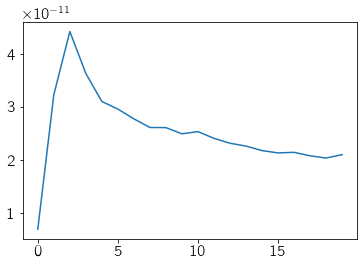

In [982]:
StarMag =0
Starfactor = 10**(-StarMag/2.5)
tscale = 0.5
wavescale = 1.
tmp0 = req_closedloop_calc_batch(G_coron_MID,G_OBWFS,E0_coron,E0_OBWFS,0,0,tscale,flux*Starfactor,wavescale**2*QMID,NiterBatch,dh_mask,norm)
tmp1 = tmp0['averaged_hist']
plt.plot(tmp1-contrast_floor)
print(wavescale*wMID_11*10**12)
ZernikeList = []
for pp in range(0,max_MID):
    ZernikeList.append('Segment Z' + np.str(pp));
table_MID_drift = astropy.table.Table()
MID_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for MID Modes', data = ZernikeList, dtype = str)
table_MID_drift.add_column(MID_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq >= tscale:
        value_tmp = zernike_coeffs_numaps_median*wavescale/tscale/freq
    else:
        value_tmp = zernike_coeffs_numaps_median*1.5
    MID_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_MID_drift.add_column(MID_Values_col)
table_MID_drift

5.46026548455756


<Table length=6>
$\Delta$ WFE (pm) for MID Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
             str10               float64  float64  ...  float64     float64  
------------------------------- --------- -------- ... ---------- -----------
                     Segment Z0      5.67     5.67 ...      18.90      188.99
                     Segment Z1      4.50     4.50 ...      15.00      150.01
                     Segment Z2      4.40     4.40 ...      14.66      146.63
                     Segment Z3      4.44     4.44 ...      14.78      147.84
                     Segment Z4      4.67     4.67 ...      15.55      155.53
                     Segment Z5      4.80     4.80 ...      15.99      159.89

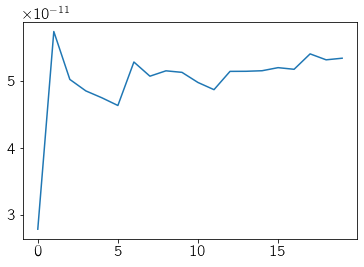

In [996]:
StarMag = 3
Starfactor = 10**(-StarMag/2.5)
tscale = 10.
wavescale = 0.5
tmp0 = req_closedloop_calc_batch(G_coron_MID,G_OBWFS,E0_coron,E0_OBWFS,0,0,tscale,flux*Starfactor,wavescale**2*QMID,NiterBatch,dh_mask,norm)
tmp1 = tmp0['averaged_hist']
plt.plot(tmp1-contrast_floor)
print(wavescale*wMID_11*10**12)
ZernikeList = []
for pp in range(0,max_MID):
    ZernikeList.append('Segment Z' + np.str(pp));
table_MID_drift = astropy.table.Table()
MID_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for MID Modes', data = ZernikeList, dtype = str)
table_MID_drift.add_column(MID_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq >= tscale:
        value_tmp = zernike_coeffs_numaps_median*wavescale/tscale/freq
    else:
        value_tmp = zernike_coeffs_numaps_median*1.5
    MID_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_MID_drift.add_column(MID_Values_col)
table_MID_drift

In [991]:
filename = 'MID_timescales.csv'
table_MID_drift.write(filename, format='csv',overwrite=True)
filename = 'MID_timescales.tex'
table_MID_drift.write(filename, format='latex',overwrite=True)

In [843]:
StarMag =0
Starfactor = 10**(-StarMag/2.5)
tscale = 0.8
wavescale = 1.5

In [844]:
tmp0 = req_closedloop_calc_batch(G_coron_MID,G_OBWFS,E0_coron,E0_OBWFS,0,0,tscale,flux*Starfactor,wavescale**2*QMID,NiterBatch,dh_mask,norm)
#tmp0 = req_closedloop_calc_batch(G_coron_LO,G_LOWFS,E0_coron,E0_LOWFS,0,0,tscale,flux*Starfactor,wavescale**2*QLO,Niter)

16.38079645367268


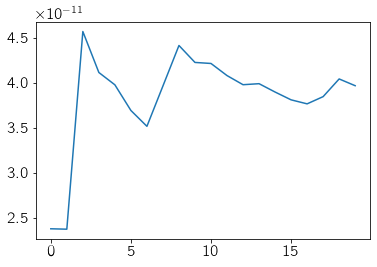

In [845]:
tmp1 = tmp0['averaged_hist']
plt.plot(tmp1-contrast_floor)
print(wavescale*wMID_11*10**12)

In [846]:
ZernikeList = []
for pp in range(0,max_MID):
    ZernikeList.append('Segment Z' + np.str(pp));
table_MID_drift = astropy.table.Table()
MID_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for MID Modes', data = ZernikeList, dtype = str)
table_MID_drift.add_column(MID_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq >= tscale:
        value_tmp = zernike_coeffs_numaps_median*wavescale/tscale/freq
    else:
        value_tmp = zernike_coeffs_numaps_median*1.5
    MID_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_MID_drift.add_column(MID_Values_col)
table_MID_drift

<Table length=6>
$\Delta$ WFE (pm) for MID Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
             str10               float64  float64  ...  float64     float64  
------------------------------- --------- -------- ... ---------- -----------
                     Segment Z0      5.67     5.67 ...     708.73     7087.25
                     Segment Z1      4.50     4.50 ...     562.53     5625.32
                     Segment Z2      4.40     4.40 ...     549.85     5498.55
                     Segment Z3      4.44     4.44 ...     554.40     5544.03
                     Segment Z4      4.67     4.67 ...     583.23     5832.30
                     Segment Z5      4.80     4.80 ...     599.60     5995.95

In [847]:
filename = 'Table_MID_drift_mag_0.csv'
table_MID_drift.write(filename, format='csv',overwrite=True)
filename = 'Table_MID_drift_mag_0.tex'
table_MID_drift.write(filename, format='latex',overwrite=True)

In [777]:
tscale = 0.1
wavescale = 3.

In [778]:
ZernikeList = []
for pp in range(0,max_MID):
    ZernikeList.append('Segment Z' + np.str(pp));
table_MID_drift = astropy.table.Table()
MID_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for MID Modes', data = ZernikeList, dtype = str)
table_MID_drift.add_column(MID_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq > tscale:
        value_tmp = zernike_coeffs_numaps_median*wavescale/tscale/freq
    else:
        value_tmp = zernike_coeffs_numaps_median*1.5
    MID_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_MID_drift.add_column(MID_Values_col)
table_MID_drift

<Table length=6>
$\Delta$ WFE (pm) for MID Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
             str10               float64  float64  ...  float64     float64  
------------------------------- --------- -------- ... ---------- -----------
                     Segment Z0      5.67     5.67 ...   11339.60   113396.03
                     Segment Z1      4.50     4.50 ...    9000.51    90005.08
                     Segment Z2      4.40     4.40 ...    8797.68    87976.77
                     Segment Z3      4.44     4.44 ...    8870.45    88704.52
                     Segment Z4      4.67     4.67 ...    9331.68    93316.80
                     Segment Z5      4.80     4.80 ...    9593.52    95935.24

# HI Modes

HI batch DH

In [779]:
StarMag =5
Starfactor = 10**(-StarMag/2.5)
tscale = 100.
wavescale = 0.1

In [780]:
tmp0 = req_closedloop_calc_batch(G_coron_HI,G_coron_HI_DH,E0_coron,E0_coron_DH,0,0,tscale,flux*Starfactor,wavescale**2*QHI,NiterBatch,dh_mask,norm)

0.4450331669357067


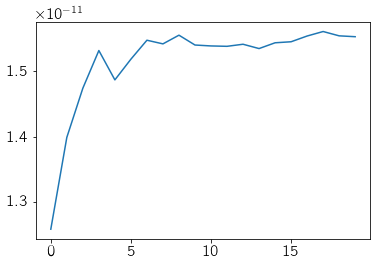

In [781]:
tmp1 = tmp0['averaged_hist']
plt.plot(tmp1-contrast_floor)
print(wavescale*wHI_11*10**12)

In [795]:
SFreq = np.asarray(SFreq)
table_HI_drift = astropy.table.Table()
HI_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for HI Modes', data = SFList, dtype = str)
table_HI_drift.add_column(HI_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq > tscale:
        value_tmp = SFreq*wavescale/tscale/freq
    else:
        value_tmp = SFreq*0.5
    HI_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_HI_drift.add_column(HI_Values_col)
table_HI_drift

<Table length=2>
$\Delta$ WFE (pm) for HI Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
            str10               float64  float64  ...  float64     float64  
------------------------------ --------- -------- ... ---------- -----------
                     Inside DH      0.23     0.23 ...       0.23        0.47
                    Oustide DH      1.66     1.66 ...       1.66        3.32

In [797]:
tscale = 10
wavescale = 3.

In [799]:
SFreq = np.asarray(SFreq)
table_HI_drift = astropy.table.Table()
HI_Labels_col = astropy.table.Table.Column(
        name = '$\Delta$ WFE (pm) for HI Modes', data = SFList, dtype = str)
table_HI_drift.add_column(HI_Labels_col)
for freq in budget_frequencies:
    label_tmp ='at ' + np.str(freq) + ' Hz'
    if 1/freq > tscale:
        value_tmp = SFreq*wavescale/tscale/freq
    else:
        value_tmp = SFreq*0.5
    HI_Values_col = astropy.table.Table.Column(
        name = label_tmp,
        data = value_tmp, dtype = float, format="7.2f")
    table_HI_drift.add_column(HI_Values_col)
table_HI_drift

<Table length=2>
$\Delta$ WFE (pm) for HI Modes at 100 Hz at 25 Hz ... at 0.01 Hz at 0.001 Hz
            str10               float64  float64  ...  float64     float64  
------------------------------ --------- -------- ... ---------- -----------
                     Inside DH      0.23     0.23 ...      14.06      140.56
                    Oustide DH      1.66     1.66 ...      99.71      997.13

# SHIIT to keep

In [159]:
res = np.zeros([Ntimes,Nwavescale,Nflux,1])
pp = 0
for tscale in np.logspace(TimeMinus,TimePlus,Ntimes):
    qq = 0
    print(tscale)
    for wavescale in np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale):
        rr = 0
#         print(wavescale)
        for StarMag in np.linspace(fluxMinus,fluxPlus,Nflux):
#             print(StarMag)
            Starfactor = 10**(-StarMag/2.5)
            tmp0 = req_closedloop_calc_batch(G_coron_HI_nyquist,G_coron_HI_DH_nyquist,E0_coron_nyquist,E0_coron_DH_nyquist,0,0,tscale,flux*Starfactor,wavescale**2*QHI,NiterBatch,dh_mask_nyquist,norm_nyquist)
            tmp1 = tmp0['averaged_hist']
            n_tmp1 = len(tmp1)
            res[pp,qq,rr] = np.mean(tmp1[np.int(n_tmp1/2):n_tmp1])
            rr = rr + 1
        qq = qq + 1
    pp = pp + 1
res_line = np.reshape(res,[Ntimes*Nwavescale*Nflux])
np.savetxt("HIbatchDH.csv", res_line, delimiter=",")

0.01


/Users/pueyo/anaconda3/envs/pastis-new-hcipy/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  app.launch_new_instance()


0.01947483039908756
0.0379269019073225
0.07386199822079362
0.14384498882876628
0.2801356761198869
0.545559478116852
1.062467830894041
2.06913808111479
4.029611320200404
7.847599703514615
15.283067326587688
29.763514416313193
57.96393953384973
112.88378916846884
219.8392648862289
428.13323987193957
833.78222347179
1623.7767391887242
3162.2776601683795


In [209]:
# res_line = np.reshape(res*norm_nyquist_shit/norm_nyquist,[Ntimes*Nwavescale*Nflux])
# np.savetxt("HIbatchDH.csv", res_line, delimiter=",")

est. contrast 4.048898076671073e-11
est. contrast 5.6123911862010666e-11
est. contrast 5.87263479188192e-11
est. contrast 6.039897544200151e-11
est. contrast 6.109835107302398e-11
est. contrast 6.168045904596791e-11
est. contrast 6.197662619789203e-11
est. contrast 6.249506965158793e-11
est. contrast 6.283993803713942e-11
est. contrast 6.293559523581396e-11


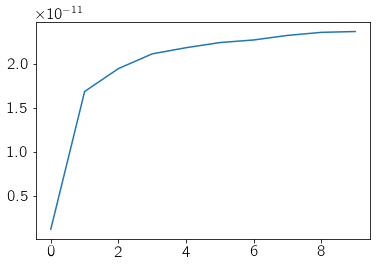

In [79]:
# tscale = 0.1
# wavescale = 1.
tscale = 100.
wavescale = 0.03
test = req_closedloop_calc_batch(G_coron_HI,G_coron_HI_DH,E0_coron,E0_coron_DH,0,0,tscale,flux/100/10,wavescale**2*QHI,10)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

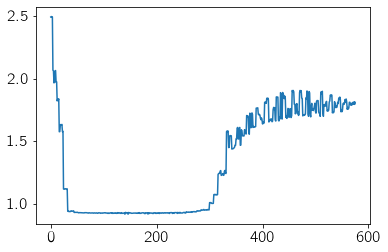

In [80]:
plt.plot(np.log10(mu_mapHI*1000*600*wavescale))

HI rescursive DH

est. contrast 4.059037531045016e-11
est. contrast 4.079182415829553e-11
est. contrast 4.1236701475941604e-11
est. contrast 4.153205617903998e-11
est. contrast 4.1674895365832405e-11
est. contrast 4.187619495250028e-11
est. contrast 4.2023997095186505e-11
est. contrast 4.213570653864529e-11
est. contrast 4.232020443989339e-11
est. contrast 4.241413007189952e-11
est. contrast 4.254155107083694e-11
est. contrast 4.267645348507331e-11
est. contrast 4.274318564146681e-11
est. contrast 4.279885927353387e-11
est. contrast 4.2851032034733974e-11
est. contrast 4.294359533284634e-11
est. contrast 4.301835705223033e-11
est. contrast 4.30644280686292e-11
est. contrast 4.310358327781117e-11
est. contrast 4.3147514288080965e-11
est. contrast 4.317883437827393e-11
est. contrast 4.3199055634393544e-11
est. contrast 4.3229745840192755e-11
est. contrast 4.3272530438043364e-11
est. contrast 4.3283111595641855e-11
est. contrast 4.3297986404366023e-11
est. contrast 4.334945237966469e-11
est. contrast 4.338

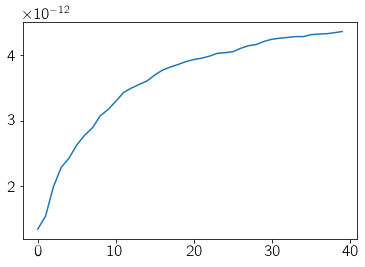

In [81]:
tscale = 0.1
wavescale = 1.
test = req_closedloop_calc_recursive(G_coron_HI,G_coron_HI_DH,E0_coron,E0_coron_DH,0,0,tscale,flux,wavescale**2*QHI,40)
he = test['averaged_hist']
plt.plot(he - contrast_floor)

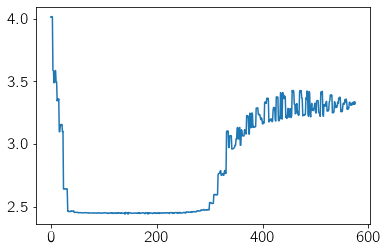

In [82]:
plt.plot(np.log10(mu_mapHI*1000*600*wavescale))